## Author : Si Dan HO

# Calibration et pricing des dérivés de taux d'intérêt

In [1]:
import time
import datetime as dt
import pandas as pd
import numpy as np
import math
import scipy.stats as sps
import scipy as sp
import scipy.optimize as spop
import matplotlib.pyplot as plt
import os

import pylab as py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

import random

Il convient tout d'abord de préciser que ce travail est à but pédagogique. En effet, n'ayant pas de données de marché en temps réel à notre disposition, il nous a été contraint de trouver des données provenant de sites internets quelconques, de dates différentes pour les Swaptions et la courbe de taux par exemple. La valorisation et la calibration n'est donc pas en temps réels et peut s'avérer faussée du fait de la différence de dates entre les données, mais il convient de rappeler qu'il ne s'agit que d'une application de la théorie sous-jacente des modèles utilisés.

# Sommaire

- Réplication et arbitrage
- Construction de la courbe de taux
- Modèle de Black
    - Valorisation d'un Caplet
    - Valorisation d'une Swaption payeuse
- Cadre de Heath-Jarrow-Morton (HJM) et Volatilité de Ho & Lee
    - Cadre de HJM
    - Volatilité de Ho & Lee
- Modèle SABR : valorisation et calibration
    - Valorisation de Caplet et Swaption sous le modèle SABR
    - Calibration du modèle SABR sur les Swaptions
        - Calibration du paramètre $\beta$
        - Première calibration du paramètre $\alpha$
        - Calibration des paramètres $\rho$ et $v$
        - Seconde calibration de $\alpha$
- Valorisation d'instruments exotiques
    - Valorisation d'un Caplet barrière Up and Out
        - Valorisation Monte Carlo sous modèle SABR
        - Variable antithétiques
        - Cas particulier de valorisation d'un Caplet sous le modèle SABR
        - Application numérique pour un Caplet Barrière
    - Valorisation d'une obligation avec clause de rappel (non fait)
- Annexe

## Réplication et arbitrage

Le but de ce paragraphe est de retrouver l'expression du taux linéaire forward à chaque instant via un raisonnement d'arbitrage. il convient de rappeler qu'un contrat forward sur un actif sous-jacent $S$ est un produit dérivé permettant à deux agents de s'échanger ce sous-jacent (respectivement achat et vente) à une date $T$ fixé et à un prix fixé (qui est le prix forward du sous-jacent) à la signature du contrat à l'instant $0$.

Par ailleurs, le juste prix de ce contrat à chaque instant doit respecter le principe d'absence d'opportunité d'arbitrage. Cela signifie qu'il n'est aucunement possible d'obtenir un gain strictement positif à partir d'un investissement nul. Plus formellement, il y a arbitrage entre les instants $0$ et $T$ pour un portefeuille autofinançant $X$ de prix $X_t$ à l'instant $t$ si:

- Sa condition initiale est nulle : $X_0 = 0$
- $\mathbb{P}[X_T \geq 0] = 1$ et $\mathbb{P}[X_T > 0] > 0$

Il convient de noter que les hypothèses d'efficience des marchés, garantissant un prix unique, ainsi que la complétude de ceux ci, permettant la réplication de l'ensemble des flux par des instruments de marché liquides, doivent être respectées dans le cadre de la valorisation au juste prix.

Sachant que le prix d'un instrument financier est le coût de sa réplication par les instruments de marché faisant l'objet d'un échange et/ou d'une cotation, il est possible de déterminer celui d'un contrat forward par un raisonnement d'arbitrage.

Ce raisonnement permet d'établir qu'en l'absence d'opportunité d'arbitrage, si l'on considère $X$ et $Y$ deux portefeuilles autofinançants, alors leur valeur sont telle que :

$$
X_T = Y_T \ \ \mathbb{P} \ p.s. \ \Longrightarrow X_t = Y_t \ \ \mathbb{P} \ p.s. \ \forall t \in [0,T]
$$

De ce fait, à l'instant $t=0$, on considère un premier portefeuille où l'on contracte un contrat forward sur un sous-jacent $S$. De ce fait, les deux parties s'engagent à s'échanger à l'instant $T$ ce sous-jacent à un prix $F_0(T)$ fixé. Il n'y a aucun échange de flux à cet instant $0$. De ce fait, la valeur de ce contrat pour l'acheteur à maturité est égale à $S_T - F_0(T)$.

Par ailleurs, on considère un second portefeuille où la stratégie suivante est adoptée à l'instant $0$:

- Acheter une unité du sous-jacent de prix $S_0$
- Vendre une quantité $F_0(T)$ d'obligations zéro coupon. Le flux lié à cette transaction est donné par : $-F_0(T)B(0,T)$

Ainsi, la valeur totale de ce portefeuille est :

- à $t=0$ : $S_0-F_0(T)B(0,T)$
- à maturité $T$ : $S_T-F_0(T)$ par désactualisation

L'absence d'opportunité d'arbitrage stipule que sachant que la valeur de ces deux portefeuilles $X$ et $Y$ à maturité $T$ sont égaux à $S_T-F_0(T)$. Alors leur prix actuel à $t=0$ doivent tout aussi être égaux. Cela donne ainsi l'équation :

$$
0 = S_0-F_0(T)B(0,T)
$$

Ainsi, le prix forward du sous-jacent $S$ est donné par :

$$
F_0(T) = \frac{S_0}{B(0,T)}
$$

Et plus généralement à tout instant $t \in [0,T]$, ce prix forward est :

$$
F_t(T) = \frac{S_t}{B(t,T)}
$$

En particulier, le montant à investir en $T$ pour se garantir d'un euro payé en $T+\delta$ peut être évalué en $t$ comme
le prix d'un contrat forward sur le zéro-coupon nommé $B_t(T,T+\delta)$, égal à $\frac{B(t,T+\delta)}{B(t,T)}$. 

Rappelons que le taux linéaire est le taux $L(t,T)$ telle que pour un zéro coupon $B(t,T)$ :

$$
B(t,T) = \frac{1}{1+(T-t)L(t,T)}
$$

Ce taux associé à un contrat forward sur le zéro-coupon est $L_t(T,T+\delta)$, et est nommé taux forward linéaire, c'est à dire le taux "vu" à l'instant $T$ pour des prêts zéro-coupons de ténor $\delta$ remboursant un euro à maturité.

Ce taux forward est donc tel que :

$$
B_t(T,T+\delta) = \frac{1}{1+\delta L_t(T,T+\delta)} = \frac{B(t,T+\delta)}{B(t,T)}
$$

De ce fait, la valeur du taux linéaire forward à chaque instant $t \in [0,T]$ est donné par :

$$
L_t(T,T+\delta) = \frac{1}{\delta}(\frac{B(t,T)}{B(t,T+\delta)} - 1)
$$

## Construction des courbes de taux

Il a été convenu de travailler sur des instruments financiers de taux dont le sous-jacent est celui du EURIBOR qui est le taux interbancaire Européen. Il convient ainsi de construire les courbes de taux zéro-coupon et forward à partir des données du marché du taux EURIBOR.

Traditionnellement, la courbe de taux EURIBOR est construite à partir de la cotation du marché de ses trois instruments contingents primordiaux : le Money Market, le Forward-Rate-Agreement (FRA) et le Swap sur EURIBOR. Il s'agit de la technique de Bootstrapping. Plus particulièrement :

- Le Money Market est un simple prêt à très court terme, ne dépassant pas un an, traduisant les différentes transactions interbancaires.
- Le Forward Rate Agreement est un produit dérivé utilisé par exemple lorsqu'un emprunteur souhaitant se financer à une date future $T_1$ jusqu'à une date $T_2$ souhaite bloquer les taux d'intérêts pendant la durée du prêt. De ce fait, le taux fixe d'emprunt est nommé $K$, taux auquel l'emprunteur doit rembourser sa dette. La stratégie de cotation d'un tel instrument pour le taux EURIBOR vient de la stratégie à laquelle l'acheteur place l'argent emprunté à ce taux variable, tandis qu'il devra rembourser sa dette à taux fixe $K$. Sachant qu'il n'y a aucun flux échangé lors de la signature du contrat, se produisant à l'instant $T_1$, la valorisation d'un tel produit vient naturellement.
- Le Swap de taux est un produit dérivé célèbre permettant de transformer un prêt à taux fixe en un prêt à taux variable, qui est ici l'EURIBOR + le spread de crédit. A chaque instant discret, le taux fixe est échangé avec le taux variable. Il s'agit d'un produit à long voire très long terme.

Ainsi, pour les maturités courtes de moins d'un an, c'est le taux provenant de la cotation des Money Market qui prévaudra. Entre un et deux ans, ce cera celui des Forward Rate Agreements. Enfin pour les maturité de long terme c'est à dire chaque années à compter de deux ans, il s'agira des taux de Swaps. C'est ainsi que la courbe de taux EURIBOR du marché est construite.

Malheureusement, n'ayant pu avoir accès aux taux FRA de marché du fait de leur nature Over The Counter, les rendant accessibles uniquement via un terminal Bloomberg, Il n'a pas été possible d'obtenir les données actuelles. Ainsi, il a été convenu de télécharger la courbe de taux EURIBOR de marché pour les cotations provenant du 14 Février 2018, date pour laquelle il a été possible d'obtenir l'ensemble des données nécessaires.

Il convient par ailleurs de prévenir que la courbe de taux de marché EURIBOR a été shifté parallèlement du fait de taux négatifs, afin que celle ci soit positive strictement, avant d'entamer les calculs pour calculer le taux zéro coupon et le taux forward. Il ne s'agit peut être pas d'une méthode conventionnelle mais il s'agissait de la seule méthode trouvée pour remédier à ce problème. Les taux négatifs ne sont pas modélisés par les modèles existants hormis quelques exceptions.

In [2]:
EURIBORMarketData =pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/EURIBORMarketData.xlsx")
EURIBORMarketData.head()

,T,EURIBOR,Instrument
0,0.002740,0.0011,MM
1,0.076712,0.0012,MM
2,0.161644,0.0013,MM
3,0.243836,0.0014,MM
4,0.495890,0.0019,MM


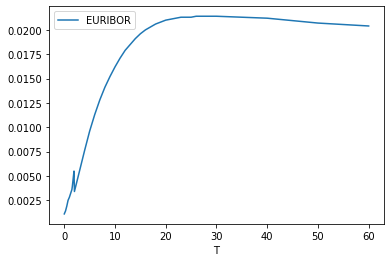

In [3]:
EURIBOR_MarketData = EURIBORMarketData[['T','EURIBOR']].set_index('T').sort_index()
EURIBOR_MarketData.plot()

A partir de la courbe de taux de marché EURIBOR, il est ainsi possible de construire de valoriser les obligations zéro-coupon à ce taux, et d'en établir une courbe dite zéro-coupon. En effet les relations entre le prix d'une obligation zéro-coupon au taux EURIBOR et les instruments financiers contingents à ce taux sont les suivantes :

- $B(0,T) = \frac{1}{1+r_MM T}$, $r_MM$ étant le taux Money Market
- $B(0,T+\delta) = \frac{B(0,T)}{1+f_{FRA}\delta}$, $f_{FRA}$ étant le taux forward prévalent à l'instant $T$ pour des prêts de ténor $\delta$
- $B(0,T_n) = \frac{1 - S_{swap} \sum_{i=1}^{n-1} B(0,T_i)}{1 + S_{swap}}$, $S_{swap}$ étant le taux Swap

Enfin, le taux zéro-coupon est calculé à partir du prix des obligations zéro coupons grâce à la formule suivante :

$$
B(0,T) = \frac{1}{1 + r_{ZC}(T)T}
$$

Ainsi, pour chaque maturité $T$, les calculs effectués parallèlement sur Excel ont permis via ces formules de valoriser dans un premier temps les obligations zéro coupons $B(0,T)$, pour ensuite construire la courbe de taux zéro-coupon $r_{ZC}(T)$, et enfin le taux forward $f_{FRA}(T,T+\delta)$ de ténor $\delta = 0.5 = 6M$, grâce à une interpolation par spline cubique.

Les résultats sont directements téléchargés :

In [5]:
ZCAndForwardRates =pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/ZCandForwardRate.xlsx")
ZCAndForwardRates.head()

,T,ZCBond,ZCRate,6MForwardRate
0,0.002740,0.999997,0.0011,0.001929
1,0.076712,0.999908,0.0012,0.002295
2,0.161644,0.999790,0.0013,0.002683
3,0.243836,0.999659,0.0014,0.003026
4,0.495890,0.999059,0.0019,0.003682


Cela permet ainsi de tracer la courbe de taux zéro-coupon et la courbe Forward de ténor 6 mois.

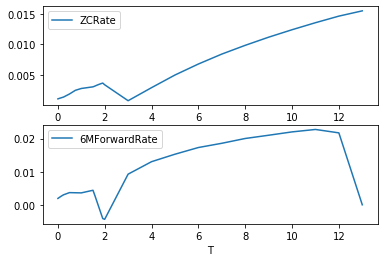

In [6]:
EURIBOR_ZCRate = ZCAndForwardRates[['T','ZCRate']].set_index('T').sort_index()
EURIBOR_ZCForward = ZCAndForwardRates[['T','6MForwardRate']].set_index('T').sort_index()

fig, ax = plt.subplots(2,1)
plt1 = EURIBOR_ZCRate.plot(ax=ax[0])
plt2 = EURIBOR_ZCForward.plot(ax=ax[1])

Les courbes de taux ayant été construites, il convient de définir le modèle de Black pour la valorisation des Caplets et des Swaptions sur EURIBOR :

## Modèle de Black

La démonstration mathématique de la formule close de valorisation des Caplets et des Swaptions sous le modèle de Black sera développée en annexe. Seules les grandes lignes seront ici exposées :

### Valorisation d'un Caplet 

Il existe plusieurs produits dérivés de taux d'intérêts. L'un des plus connus est le caplet, un produit dérivé vanille pouvant être considéré comme une option d'achat (ou Call) dont le sous-jacent est un taux d'intérêt. Ainsi le détenteur d'un caplet peut se prémunir d'une hausse de taux d'intérêt et obtenir in fine un payoff à l'instant $T+\delta$ lorsque le taux variable $L(T,T+ \delta)$ qui prévaudra à cet instant $T$ pour des prêts de maturité $\delta$ excède le Strike $K$ fixé, en ayant le droit d'emprunter ou de prêter à ce taux fixe $K$ garanti, qui est souvent proche du taux forward (d'après Huyen Pham). Ainsi, le payoff d'un caplet est donné par :

$$
\Pi_{Caplet}(T,\delta,K) = \delta(L(T, T+\delta) - K)_{+}
$$

Et en l'absence d'opportunité d'arbitrage, si l'on pose $\mathbb{Q}$ la probabilité risque neutre et $r_t$ le taux sans risque, le théorème fondamental de la valorisation des actifs permet d'établir que le prix actuel d'un caplet est donné par :

$$
Caplet(T,\delta,K) = \delta \mathbb{E}^{\mathbb{Q}}[e^{\int_0^{T+\delta} r_s ds}(L(T, T+\delta) - K)_{+}]
$$

Si l'on pose $L_f(t,T,T+\delta)$ le taux forward à l'instant $t$ expirant à l'instant $T$ et de maturité $T+ \delta$, celui ci est tel que :

$$
L_f(t,T,T+\delta) = \frac{1}{\delta}(\frac{B(t,T)}{B(t,T+\delta)} -1)
$$

de sorte à pouvoir introduire la probabilité $T+\delta$ forward neutre, écrite $\mathbb{Q}^{T+\delta}$ équivalente à la probabilité risque neutre $\mathbb{Q}$, définie telle que :

$$
\frac{d\mathbb{Q}^{T+\delta}}{d\mathbb{Q}}= Z_t^{T+\delta} = \frac{e^{\int_t^{T+\delta} r_s ds}}{\mathbb{E}^{\mathbb{Q}}[e^{\int_t^{T+\delta} r_s ds}|\mathcal{F}_t]}
$$

Et le numéraire associé à cette probabilité est $B(t,T+\delta)$.

Cette probabilité permet ainsi par changement de numéraire selon la $T+\delta$ probabilité risque neutre d'établir que le taux forward interbancaire $L_f(t,T,T+\delta)$, que l'on nommera $L_t$ en tant que processus stochastique, est une martingale sous cette probabilité. Par ailleurs, cela implique que le prix actuel d'un Caplet est donné par :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L(T, T+\delta) - K)_{+}]
$$

Et sous le modèle Black, il est supposé que la volatilité du taux forward est constante par rapport au temps, dépendant simplement de la maturité $T$, du ténor $\delta$ et du Strike $K$ du caplet. De ce fait, sa dynamique sous le modèle de Black est donnée par :

$$
\frac{dL_t}{L_t} = \sigma(T,\delta,K)dW^{\mathbb{Q}^{T+\delta}}_t
$$

De ce fait, la démonstration en annexe permet d'établir la formule de Black pour un Caplet de Strike $K$, de maturité $T$ et de ténor $\delta$ :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta)(L_0\mathcal{N}(d)- K\mathcal{N}(d-v))
$$

avec $d = \frac{1}{v}(ln(\frac{L_0}{K}) +\frac{v^2}{2})$ avec $v =\sigma(T,\delta,K)\sqrt{T}$.

En se rappelant que $L_0 = L(0,T,T+\delta)$ est le taux actuel forward de maturité $T$ et de ténor $\delta$. Ainsi, le modèle de Black pour valoriser un caplet peut être numériquement implémenté comme suit :

In [7]:
def BlackCaplet(T,delta,sigma,B0, L0, K) :
    v = sigma*math.sqrt(T)
    d = (1/v)*(math.log(L0/K) - 0.5*(v**2))
    Caplet = delta*B0*(L0*sps.norm.cdf(d) - K*sps.norm.cdf(d-v))
    return Caplet

Considérons de ce fait un caplet EURIBOR 6 mois de maturité 1 an et dans la monnaie sachant que le marché côte une volatilité Black de 30%. Son prix actuel est donc calculé, sachant que de ce fait,

- $T = 1$
- $\delta = 6m = 0.5$
- $\sigma = 30\%$

Par ailleurs, le prix actuel de l'obligation zéro coupon $B(0,T+\delta)$ et le taux forward $L_0 = L(0,T,T+\delta)$ sont donnés par :

In [8]:
B0 = ZCAndForwardRates[round(ZCAndForwardRates['T'],2) == 1.50]['ZCBond'].iloc[0]
L0 = ZCAndForwardRates[round(ZCAndForwardRates['T'],2) == 1.00]['6MForwardRate'].iloc[0]
print('Zero coupon Maturité 1.5=%.3f, Taux forward Maturité 1 et Ténor 0.5=%.3f' % (B0, L0))

Zero coupon Maturité 1.5=0.995, Taux forward Maturité 1 et Ténor 0.5=0.004


Ainsi, la formule de Black peut être calculé pour ce caplet particulier :

In [9]:
T=1
delta = 0.5
sigma = 0.30
K = L0

CapletBlack1 = BlackCaplet(T,delta,sigma,B0, L0, K)
print("Le prix Black d'un Caplet EURIBOR 6 mois ATM et de Mat 1 an avec une volatilité Black de 0.30 est égal %f" % (CapletBlack1))

Le prix Black d'un Caplet EURIBOR 6 mois ATM et de Mat 1 an avec une volatilité Black de 0.30 est égal 0.000204


### Valorisation d'une Swaption Payeuse

Le Swaption quant à elle, est une option de Swap. Elle donne donc le droit, et non l'obligation, au détenteur d'exercer son swap (receveur de taux fixe dans ce projet). Plus précisément, une swaption payeuse est une option permettant d’entrer dans un swap payeur applicable au temps $T_0$, et prenant fin au temps $T_n$ (et donc de ténor $T_n - T_0$, de nominal ici égal à 1 et de strike K. Ainsi, $T_0$ est la maturité de l'option.

Ainsi, son cash-flow à maturité est simplement le maximum entre le prix du swap receveur de taux fixe évalué au temps $T_0$ et la valeur nulle. 

De ce fait, son prix au temps $t$ est donnée par  l'espérance de son cash-flow futur actualisé par le taux sans risque $r_t$, et donc :

$$
Swopt^{PAY}(t,T_0,T_n,K)=\mathbb{E}^{\mathbb{Q}}[e^{-\int_t^{T_0} r_udu}(\omega_{T_0} - K)_{+}lvl(T_0, T_n)]
$$

Où $\omega_t$ est le taux dit Swap Forward, qui est la valeur de $K$ permettant au contrat swap d'être à son Juste Prix, c'est à dire nul au temps $t$. Son expression est donné par :

$$
\omega_t = \frac{B(t,T_0) - B(t,T_n)}{lvl(t,T_n)}
$$

Avec

$$
lvl(t,T_n) =\sum_{i=0}^{n}(T_i - T_{i-1})B(t,T_i)
$$.

Ainsi donc, à l'instant $0$ le prix d'une Swaption Payeuse devient :

$$
Swopt^{PAY}(0,T_0,T_n,K)=\mathbb{E}^{\mathbb{Q}}[e^{-\int_0^{T_0} r_udu}(\omega_{T_0} - K)_{+}lvl(T_0, T_n)]
$$

Il est possible d'effectuer un changement de numéraire selon la probabilité Duration $\mathbb{Q}^{lvl}$ et de constater que le processus $\omega_t$ est une martingale sous cette probabilité. Sachant que pour un processus $X_t$, la formule de pricing est la suivante :

$$
X_t = lvl(t, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[\frac{X_T}{lvl(T, T_n)}|F_t]
$$

Nous pouvons établir que le prix actuel du swaption est :

$$
Swopt^{PAY}(0,T_0,T_n,K)=lvl(0, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[\frac{P_{Swaption}(T_0,T_0,T_n,K)}{lvl(T_0, T_n)}|F_0]
$$

Et étant donné que son prix à sa maturité $T_0$ est égal à son cash flow (qui est déterministe) et donc égal à :

$$
Swopt^{PAY}(T_0,T_0,T_n,K) = (\omega_{T_0} - K)_{+}lvl(T_0, T_n)
$$

Alors le prix final du Swaption est égal à :

$$
Swopt^{PAY}(0,T_0,T_n,K)= lvl(0, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[(\omega_{T_0} - K)_{+}]
$$

Et sachant que $\omega_t = \frac{B(t,T_0) - B(t,T_n)}{lvl(t,T_n)}$ est une martingale sous la probabilité Duration $\mathbb{Q}^{lvl}$, alors en supposant sa volatilité constante par rapport au temps $t$, mais exprimée en fonction du Strike $K$, de la maturité $T_0$ et du ténor $T_n - T_0$ (volatilité qui est aussi celle côtée sur le marché), sa dynamique sous cette probabilité est donnée par :

$$
\frac{d\omega_t}{\omega_t} = \sigma(T_0,T_n,K)dW^{\mathbb{Q}^{lvl}}_t
$$

Et un calcul analogue d'espérance que celui effectué pour la valorisation d'un caplet permet ainsi d'établir la formule de Black dans le cas d'une swaption payeuse :

$$
Swopt^{PAY}(0,T_0,T_n,K) = lvl(0, T_n)(\omega_0\mathcal{N}(d)- K\mathcal{N}(d-v))
$$

Avec :$d = \frac{1}{v}(ln(\frac{\omega_0}{K}) +\frac{v^2}{2})$ avec $v =\sigma(T_0,T_n,K)\sqrt{T_0}$.

Ainsi, le modèle de Black pour la valorisation d'une Swaption Payeuse peut être numériquement implémenté comme suit :

In [10]:
def BlackSwopt(T0,Tn,n,delta,sigma, K) :
    # on définit le pas de temps entre T0 et Tn
    Delta = (Tn - T0)/n
    
    # On définit le vecteur de temps entre T0 et TN
    Time = [T0 + i*Delta for i in range(n)]
    # On définit la prix des zéro coupons entre T0 et Tn avec le taux swap EURIBOR
    ZCBondSwap = [0 for i in range(n)]
    for i in range(n):
        SwapRate = EURIBORMarketData[round(EURIBORMarketData['T'],2) == Time[i]]['EURIBOR'].iloc[0]
        ZCBondSwap[i] = math.exp(-SwapRate*Time[i])
    
    # On définit la quantité lvl(0,Tn)
    lvl_0T = Delta*sum(ZCBondSwap)
    
    # On définit le taux swap forward w0
    w0 = (ZCBondSwap[n]- ZCBondSwap[0])/lvl_0T
    
    # Calcul de la formule Black
    v = sigma*math.sqrt(Tn)

    d = (1/v)*(math.log(w0/K) - 0.5*(v**2))
    Swopt = lvl0*(w0*sps.norm.cdf(d) - K*sps.norm.cdf(d-v))
    return Swopt

## Cadre de Heath-Jarrow-Morton (HJM) et Volatilité de Ho & Lee

Une fois de plus, les résultats mathématiques résultant du cadre de Heath-Jarrow-Morton et du modèle de Ho & Lee seront démontrés en détail dans l'Annexe.

### Cadre de Heath-Jarrow-Morton

#### Dynamique du taux forward et  des zéro-coupons , et hypothèse d'absence d'opportunité d'arbitrage :

Le framework de Heath-Jarrow-Morton spécifie la dynamique des taux forward $f(t,T)$ via leur volatilité locale de la manière suivante, en posant $\alpha(t,T)$ et $\sigma(t,T)$ des processus $\mathcal{F}_t$ adaptés :

$$
\left\{
    \begin{array}{ll}
    df(t,T) = \alpha(t,T)dt + \sigma(t,T)dW_t \\
    f(0,T) = f^{m}(0,T)
    \end{array}
\right.
$$

où $f^{m}(0,T)$ est le taux forward observé sur le marché. 

Par ailleurs, le taux forward peut s'exprimer en fonction du prix d'une obligation zéro coupon comme suit :

$$
f(t,T) = -\frac{\partial ln B(t,T)}{\partial T}
$$

Ce qui permet d'établir la dynamique de cette dernière sous ce cadre, donnée par :

$$
dB(t,T) = B(t,T)[(r_t -A(t,T) + \frac{1}{2} \Sigma(t,T)^2) dt - \Sigma(t,T)dW_t]
$$

En posant :

- $A(t,T) = \int_t^T \alpha(t,u)dudt$
- $\Sigma(t,T) = \int_t^T \sigma(t,u)du$

Enfin, la démonstration qui sera effectuée en annexe permet d'établir qu'il y a absence d'opportunité d'arbitrage sous le cadre HJM si le drift du taux forward dépend entièrement de la volatilité $\sigma(t,T)$, et est égale à :

$$
\alpha(t,T) = \sigma(t,T)\Sigma(t,T) = \sigma(t,T)\int_t^T \sigma(t,u)du
$$

#### Formule de Black sous le cadre de Heath-Jarrow-Morton

Il convient de rappeler que sous la probabilité $T+\delta$ forward neutre, le prix d'un Caplet est donnée par :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L(T, T+\delta) - K)_{+}]
$$

De ce fait, en posant $\beta_{T,\delta}(t) = \frac{B(t,T)}{B(t,T+\delta)}$, l'expression devient :

$$
Caplet(T,\delta,K) =  B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(\beta_{T,\delta}(T) - (1 + \delta K))_{+}]
$$

Il est par ailleurs possible de remarquer que le processus $\beta_{T,\delta}(t)$suit une martingale sous la probabilité $T+\delta$ forward neutre grâce au changement de numéraire associé. Et sous le cadre HJM, sa dynamique associée sous cette probabilité est donnée par :

$$
d\beta_{T,\delta}(t) = \beta_{T,\delta}(t)(\Sigma(t,T+\delta) - \Sigma(t,T))dW^{\mathbb{Q}^{T+\delta}}_t
$$

Cela permet ainsi d'obtenir une formule de type Black pour les Caplets sous le cadre HJM :

$$
Caplet(T,\delta,K) =   B(0,T+\delta) (\beta_{T,\delta}(0)\mathcal{N}(d)- (1+\delta K)\mathcal{N}(d-v))
$$

avec :

$$d = \frac{1}{V(T)}(ln(\frac{\beta_{T,\delta}(0)}{1+\delta K}) +\frac{V^2(T)}{2}) = \frac{1}{V(T)}(ln(\frac{B(0,T)}{B(0,T+\delta)(1+\delta K)})) +\frac{V^2(T)}{2})
$$ 

et 

$$ 
V(T) = \int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt
$$

Ainsi, le prix d'un caplet selon la formule de Black dans le cadre de Heath-Jarrow-Morton peut s'écrire comme le produit du prix actuel $B(0,T+\delta)$ d'un zéro coupon de maturité $T+\delta$ et du prix Black d'un Call avec les paramètres suivant :

- Forward : $\beta_{T,\delta}(0) = \frac{B(0,T)}{B(0,T+\delta)}$
- Strike : $1 +\delta K$
- Maturité : $T$
- volatilité de Black : $\sigma^B = V(T) = \int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt$

### Volatilité de Ho & Lee

#### Dynamique des taux forward et prix des obligations zéro-coupons

Etant donné que le cadre de Heath-Jarrow-Morton est vaster et qu'il existe une multitude de modèle, il convient de spécifier précisément la forme de la volatilité $\sigma(t,T)$ du taux forward $f(t,T)$ à partir d'un certain modèle. De ce fait, l'un des modèles les plus connues est celle établie par Ho & Lee, qui suppose tout simplement que cette volatilité est constante :

$$
\sigma(t,T) = \sigma
$$

De ce fait, $\Sigma(t,T) = \sigma^2 (T-t)$ et la dynamique du taux forward est donnée par :

$$
df(t,T) = \sigma^2 (T-t) + \sigma dW^{\mathbb{Q}}_t
$$

Il convient ainsi d'établir le prix d'une obligation zéro-coupon en tout instant. En posant $X_t = r_t - f(0,t) = - \sigma^2 \frac{t^2}{2} + \sigma W^{\mathbb{Q}}_t$, par une simple application de la formule d'Itô, la dynamique de ce processus est égale à :

$$
dX_t = \sigma^2 tdt + \sigma dW^{\mathbb{Q}}_t
$$

Et la démonstration effectuée en annexe permet d'établir que le prix d'un zéro-coupon sous le modèle de Ho & Lee est donnée par :

$$
B(t,T) =\frac{B(0,T)}{B(0,t)} exp(-{\sigma^2}{2}t(T-t)^2 -X_t (T-t))
$$

#### Formule de Black pour les Caplets sous la volatilité de Ho & Lee

Par ailleurs sachant que sous le modèle de Ho & Lee, $\Sigma(t,T) = \sigma (T-t)$, alors :

$$
V(T) = \int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt = \sigma^2 \int_0^T \delta^2 dt = \sigma^2 \delta^2 T
$$

Sachant que le modèle de Ho & Lee est directement issu du cadre de Heath-Jarrow-Morton avec ici $V^2(T) =\sigma^2 \delta^2 T$, alors d'après le résultat précédent, il est donc possible d'obtenir le prix d'un caplet sous ce modèle :

$$
Caplet(T,\delta,K) =   B(0,T+\delta) (\beta_{T,\delta}(0)\mathcal{N}(d)- (1+\delta K)\mathcal{N}(d-V(T)))
$$

avec $d = \frac{1}{V(T)}(ln(\frac{\beta_{T,\delta}(0)}{1+\delta K}) +\frac{V^2(T)}{2}) = \frac{1}{V(T)}(ln(\frac{B(0,T)}{B(0,T+\delta)(1+\delta K)})) +\frac{V^2(T)}{2})$ avec $V(T) =\sigma \delta\sqrt{T}$

Ainsi, le prix d'un caplet sous le modèle de Ho & Lee peut s'écrire comme le produit du prix actuel $B(0,T+\delta)$ d'un zéro coupon de maturité $T+\delta$ et du prix Black d'un Call avec les paramètres suivant :

- Paramètre Spot : $\beta_{T,\delta}(0) = \frac{B(0,T)}{B(0,T+\delta)}$
- Strike : $1 +\delta K$
- Maturité : $T$
- volatilité Black: $\sigma^B = V(T) = \sigma^2 \delta^2\sqrt{T}$

### Calibration du modèle sur les Caplets

En remarquant que $\beta_{T,\delta}(0) = 1 + \delta L(0,T,T+\delta)$, il convient d'implémenter la formule Black du modèle de Ho & Lee pour les caplets.

In [11]:
def HoLeeCaplet(T,delta,sigma,B0, L0, K):
    Beta0 = 1 + delta*L0
    v = (sigma**2)*(delta**2)*math.sqrt(T)
    d = (1/v)*(math.log(Beta0/K) - 0.5*(v**2))
    Caplet = delta*B0*(Beta0*sps.norm.cdf(d) - (1+delta*K)*sps.norm.cdf(d-v))
    return Caplet

Il convient de trouver la volatilité de Ho & Lee $\sigma_{HL}$ qui est telle que le prix du Caplet selon le modèle de Ho & Lee soit égal à celui de Black :

$$
C_{HL}(\sigma_{HL}, T, \delta, K) = C_{Black}(\sigma_{Black}, T, \delta, K)
$$

In [12]:
B0 = ZCAndForwardRates[round(ZCAndForwardRates['T'],2) == 1.50]['ZCBond'].iloc[0]
L0 = ZCAndForwardRates[round(ZCAndForwardRates['T'],2) == 1.00]['6MForwardRate'].iloc[0]
T=1
delta = 0.5
sigma = 0.30
K = L0

# Définition condition initiale
m = B0*(L0/K)
sigma_0 = math.sqrt(2*abs(math.log(m))/T)

# Calcul de la volatilité implicite
func = lambda sigma : HoLeeCaplet(T,delta,sigma,B0, L0, K) - CapletBlack1
Ho_Lee_Volatility = spop.fsolve(func, x0 = sigma_0)
print("La volatilité Ho & Lee du Caplet précédent de volatilité Black 0.30 est égal à %f" % (CapletBlack1))

La volatilité Ho & Lee du Caplet précédent de volatilité Black 0.30 est égal à 0.000204


C:\Users\Si Dan\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Le risque lié au Smile de volatilité des produits dérivés de taux, notamment les Caplets et Swaption étant très présent, et dont le modèle de Black est incapable de modéliser, une des solution consiste à utiliser le modèle à volatilité stochastique SABR, où la volatilité du taux forward est stochastique et possède une dynamique propre à elle selon un certain système d'équations différentielles stochastiques.

## Modèle SABR : valorisation et calibration

### Valorisation des caplets et des swaptions sous le modèle SABR

Le modèle SABR est un modèle à volatilité stochastique spécifiant la dynamique des prix forward c'est à dire un taux forward LIBOR/EURIBOR, un taux forward swap ou le prix forward d'un indice quelconque, en considérant sa volatilité stochastique. Plus précisément, le système d'équation différentielle stochastique pour un taux forward est donnée sous ce modèle et sous la probabilité forward $\mathbb{Q}^T$ par :

$$
\left\{
    \begin{array}{lll}
    dF_t =  \sigma_t F_t^{\beta} dW_t^1 \\
    d\sigma_t = v\sigma_t dW_t^2 \\
    \mathbb{E}^{\mathbb{Q}^T}[dW_t^1,dW_t^2] = d<W^1,W^2>_t =  \rho dt
    \end{array}
\right.
$$

Avec comme condition initiale $F_0$ et $\sigma_0 = \alpha$.

A l'instar de plusieurs modèles de volatilité locale, le modèle SABR est célèbre pour sa capacité à donner une formule explicite approximative de la volatilité implicite, fonction du forward $f$ et du strike $K$, ce qui permet de résoudre le problème classique du Smile de volatilité dans la gestion des risques des produits de taux, qui reste l'un des plus grands inconvénients de l'univers traditionnel de Black. Dans le cas de taux forward négatifs, plusieurs variantes existent, comme l'introduction d'un shift ou d'une valeur absolue dans la dynamique du taux forward.

En effet, Hagan & Al ont pu démontrer que cette fonction approximative était telle que, en posant $f$ le taux forward actuel qui sera égal à $F_0$ :

$$
\sigma_{imp}(f,K) \approx \frac{\alpha}{(f K)^{(1-\beta)/2}[1+\frac{(1-\beta)^2)}{24}log^2(f/K) + \frac{(1-\beta)^2}{1920}log^4(f/K)]}(\frac{z}{\chi(z)})(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(fK)^{1-\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)
$$

avec :

- $z = \frac{v}{\alpha}(fK)^{(1-\beta)/2}ln(\frac{f}{K})$
- $\chi(z) = ln[\frac{\sqrt{1-2\rho z + z^2}+ z - \rho}{1- \rho}]$

Et plus particulièrement, pour les options At the Money Forward c'est à dire celles pour lesquelles $f = K$, cette volatilité implicite devient :

$$
\sigma_{ATM}(f,f) \approx \frac{\alpha}{f^{1-\beta}}(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{f^{2-2\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{f^{1-\beta}}+\frac{2-3\rho^2}{24}v^2]T)
$$

Les paramètres du modèle SABR sont :

- $\alpha$ la volatilité instantanée
- $v$ la volatilité de volatilité
- $\rho$ la corrélation entre les mouvements browniens du système d'EDS
- $\beta$ est la composante CEV du taux forward

La volatilité implicite du modèle SABR étant celle permettant au modèle de Black d'établir un prix de Caplet ou de Swaption égal à celui calculé par le modèle SABR, c'est à dire si on se place à l'instant actuel $0$ :

$$
C_{BS}(\sigma_{imp},T,F_0,K) = C_{SABR}(T,F_0,K)
$$

il s'ensuit que le prix d'un caplet et d'un swaption sous le modèle SABR se calcule en utilisant leur formule de Black respectives en réinjectant la volatilité implicite de SABR en tant que paramètre :

pour un Caplet de Strike $K$, de maturité $T$ et de ténor $\delta$ :

$$
Caplet_{SABR}(T,\sigma_{SABR}, \delta,K) = \delta B(0,T+\delta)(L_0\mathcal{N}(d)- K\mathcal{N}(d-v))
$$

avec $d = \frac{1}{v}(ln(\frac{L_0}{K}) +\frac{v^2}{2})$ avec $v =\sigma_{SABR}\sqrt{T}$.

Et pour une Swaption payeuse applicable à l'instant $T_0$ et prenant fin à l'instant $T_n$ :

$$
Swopt_{SABR}^{PAY}(0,\sigma_{SABR},T_0,T_n,K) = lvl(0, T_n)(\omega_0\mathcal{N}(d)- K\mathcal{N}(d-v))
$$

Avec :$d = \frac{1}{v}(ln(\frac{\omega_0}{K}) +\frac{v^2}{2})$ avec $v =\sigma_{SABR}\sqrt{T_0}$.

### Calibration du modèle sur les Swaptions

La calibration du modèle SABR consiste à rechercher les paramètres optimaux $\alpha$, $v$, $\rho$ et $\beta$ permettant de fitter au mieux la fonction de volatilité implicite SABR avec celle du marché des Caplets et des Swaptions. Seul le cas des Swaptions L'expression de la formule explicite de la volatilité implicite pour les options At the money est fortement efficace permet une calibration rapide pour chaque maturité des Swaptions.

Malheureusement, les données marché des Caplets et des Swaptions ne sont disponible qu'à partir d'un terminal Bloomberg. Cependant, il a été possible d'obtenir un jeu de données de volatilités implicites de Swaptions selon leur maturité, leur ténor, et leur Strike, ce qui permet ainsi une calibration complète du modèle. Ce jeu de données provient des travaux de Giovanni Travaglini sur la calibration du modèle SABR.

De ce fait, ces données sont téléchargées :

In [13]:
SwaptionsIV =pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/market_data_swaption.xlsx")
SwaptionsIV.head()

,Tenor,Expiry,Forward,Strike_Spread_equal_minus_150,Strike_Spread_equal_minus_100,Strike_Spread_equal_minus_50,Strike_Spread_equal_minus_25,Strike_Spread_equal_0,Strike_Spread_equal_25,Strike_Spread_equal_50,Strike_Spread_equal_100,Strike_Spread_equal_150
0,2,0.25,0.010764,0.0,1.0470,0.4812,0.4327,0.4268,0.4148,0.4253,0.4322,0.4495
1,2,0.50,0.011099,0.0,0.9647,0.5079,0.4637,0.4477,0.4390,0.4377,0.4452,0.4576
2,2,0.75,0.011602,0.0,0.8253,0.5033,0.4648,0.4494,0.4387,0.4348,0.4375,0.4463
3,2,1.00,0.012194,0.0,0.6796,0.4788,0.4474,0.4501,0.4435,0.4478,0.4611,0.4754
4,2,2.00,0.016196,0.0,0.9119,0.5417,0.4628,0.4529,0.4461,0.4386,0.4387,0.4442


Il convient de préciser qu'excepté pour Tenor, Expiry et Forward, l'ensemble des colonnes correspond à la valeur de la volatilité implicite du Swaption pour un Strike donné, côté en bps, signifiant par exemple qu'un Strike de 150 bps équivant à une valeur de 0.015.

Ainsi, en posant le set de paramètres $\theta = \{\alpha, \rho, \beta, v \}$, une approche intuitive de la calibration du modèle SABR consiste à trouver le set optimal $\theta_{OPT}$ qui est solution du problème de minimisation aux moindres carrés suivant, en posant $f$ le taux forward, et cela pour chaque Maturité $T$ c'est à dire chaque forward $f$, et chaque Ténor $\delta$ :

$$
\theta_{OPT} = argmin_{\theta} \sum_{i=0}^n (\sigma_{SABR}(f, K_i, \theta) - \sigma_{Mkt}(f,K_i))^2
$$

En se rappelant que :

$$
\sigma_{imp}(f,K) = \frac{\alpha}{(f K)^{(1-\beta)/2}[1+\frac{(1-\beta)^2)}{24}log^2(f/K) + \frac{(1-\beta)^2}{1920}log^4(f/K)]}(\frac{z}{\chi(z)})(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(fK)^{1-\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)
$$

Et en prenant soin de contraindre l'optimisation selon les espaces de définitions suivants :

- $\rho \in [-1,1]$
- $\beta \in [0,1]$
- $ v\geq 0$
- $\alpha > 0$

Cependant, cette approche n'est pas la plus optimale puisque calibrer conjointement l'ensemble des paramètres de manière simultanée fournirait en résultats des paramètres plus instables ou moins consistant, notamment pour le paramètre $\beta$, où il sera vu dans le paragraphe suivant qu'il n'a que très peu d'impact sur la forme du Smile de volatilité implicite. Une autre alternative en plusieurs étapes existant pour la calibration du modèle SABR, il convient de favoriser celle ci.

Pour cela, il convient de rappeler l'expression de la volatilité implicite du modèle SABR :

$$
\sigma_{ATM}(f,f) \approx \frac{\alpha}{f^{1-\beta}}(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{f^{2-2\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{f^{1-\beta}}+\frac{2-3\rho^2}{24}v^2]T)
$$

La calibration par étape commence par celle du paramètre $\beta$ uniquement, et dont il convient d'après Hagan & al. de ne point en modifier la valeur par la suite.

#### Calibration du paramètre $\beta$

La composante $\frac{\alpha}{f^{1-\beta}}$ de la volatilité implicite ATM est communément appelée Backbone, et reflète la sensibilité de cette volatilité ATM par rapport au taux forward $f$. Celle ci est quasi entièrement déterminée par $\beta$, et il convient de noter que ce paramètre n'influe aucunement sur la forme du Smile de volatilité (par rapport au Strike), mais plutôt sur la manière dont toute la courbe du Smile (donnée pour une certaine maturité et un certain ténor) "shifte" par rapport au taux forward $f$.

Cela implique donc que le choix de $\beta$ n'est pas crucial puisque n'influant pas sur la courbe de volatilité implicite. Cependant, son impact est plus important dans le calcul des Greeks des produits dérivés.

Pour la calibration, il convient d'appliquer le logarithme de la volatilité implicite ATM :

$$
log(\sigma_{ATM}(f,T)) \approx log(\alpha) -(1-\beta)log(f) + log(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{f^{2-2\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{f^{1-\beta}}+\frac{2-3\rho^2}{24}v^2]T)
$$

Le troisième terme comprenant la maturité $T$ peut être négligé puisque sa valeur est en générale inférieure à $1\%$ ou $2\%$. De ce fait, l'approximation donne :

$$
log(\sigma_{ATM}(f)) \approx log(\alpha) - (1-\beta)log(f)
$$

Ainsi, $\beta$ peut être estimé naturellement par régression linéaire en prenant $log(\sigma_{ATM}(f))$ comme variable à expliquer et $log(f)$ comme variable explicative. Cette opération doit être réitérée pour chaque ténor.

Pour cela, il convient de traiter les données de marchés pour obtenir les valeurs nécessaires, sachant que les volatilités implicites ATM sont celles dont le Spread du Strike est égal à zéro :

In [14]:
import statsmodels.api as sm
    
# On filtre les données selon le Tenor du Swaption
ATMData = SwaptionsIV[['Forward','Strike_Spread_equal_0']]
# On calcule le logarithme du taux forward et de la vol
ATMData['log_Forward'] = np.log(np.array(ATMData['Forward']))

# On récupère le logarithme de la volatilité ATM pour chaque valeur du taux forward :
ATMData['log_ATMsigma'] = np.log(np.array(ATMData['Strike_Spread_equal_0']))

# On supprime es variables du Taux Forward et de la vol implicite
del ATMData['Forward']
del ATMData['Strike_Spread_equal_0']

# On crée la variable Y à expliquer et la variable X explicative en introduisant l'intercept
Y = ATMData['log_ATMsigma']
X = ATMData[['log_Forward']]
X.copy()
X['Intercept']=1
    
# On effectue la régression et on ajoute les résultats pou
modeleReg = sm.OLS(Y,X).fit()
intercept = modeleReg.params['Intercept']
coef = modeleReg.params['log_Forward']

print("Intercept = %f, Coefficient = %f" %(intercept, coef))

Intercept = -3.103625, Coefficient = -0.531547


C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Ainsi, la régression est donnée par l'expression :

$$
log(\sigma_{ATM}(f)) = Intercept + Coeff * log(f) + \epsilon, \ \epsilon \sim \mathcal{N}(0,\sigma)
$$

Or il a été vu précédemment que :

$$
log(\sigma_{ATM}(f)) \approx log(\alpha) - (1-\beta)log(f)
$$

Ce qui fait que le paramètre $\beta$ peut être exprimé comme suit, en fonction du ténor : $\beta = 1 + Coeff$.

Sachant que le coefficient de la régression effectuée précédemment est égale à $-0.531547$, cela implique que : $\beta \approx 0.5$.

Ce résultat est parfaitement cohérent. En effet, une méthode alternative à la régression pour déterminer $\beta$ aurait été de considérer trois possibilités pour $\beta$ selon le type de modèle SABR que nous souhaitons spécifier :

- $\beta = 0$ correspond au modèle stochastique log-normale, appropriée aux options FX
- $\beta = 0.5$ correspond au modèle CIR, appropriée cette fois ci aux produits de taux, ce qui est notre cas ici présent
- $\beta = 1$ correspond au modèle stochastique normale, pour des marchés où le taux forward $f$ est négatif ou nul, ce qui n'est pas le cas pour les données de Swaptions qui ont été téléchargés puisque datant de 2016, date où les taux d'intérêts ne sont pas encore négatifs.

Ainsi, le paramètre final retenu pour la suite est $\beta = 0.5$, ce qui est optimal puisqu'il doit s'agir du résultat théorique qu'il faut obtenir dans le cas des produits de taux.

Le paramètre $\beta$ étant fixé à 0.5 pour toute maturité et tout ténor, il convient de calibrer le reste des paramètres du modèle SABR.

Par ailleurs, il convient de remarquer que même si le paramètre $\alpha$ intervient dans l'expression de la constante de la régression linéaire, il a été décidé de ne pas utiliser cette dernière puisque la valeur qui en découlerait serait trop imprécise.

le paramètre $\alpha$ sera calibré conjointement de la manière suivante :

#### Première calibration du paramètre $\alpha$

Pour cela, reprenons une fois de plus l'expression de la volatilité implicite du modèle SABR :

$$
\sigma_{ATM}(f,f) \approx \frac{\alpha}{f^{1-\beta}}(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{f^{2-2\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{f^{1-\beta}}+\frac{2-3\rho^2}{24}v^2]T)
$$

Sachant que la volatilité implicite ATM est observable sur le marché, dont la valeur sera nommée $\sigma_{ATM}^{Mkt}$, cela implique que trouver le paramètre $\alpha$ optimal revient à résoudre l'équation au troisième degré suivante :

$$
A \alpha^3 + B \alpha^2 + C\alpha - \sigma_{ATM}^{Mkt}f^{1-\beta}= 0
$$

avec :

$$
A = [\frac{(1-\beta)^2T}{24 f^{2 - 2\beta}}], \ B = [\frac{\rho \beta v T}{4f^{1 - \beta}}], \ C = [1 + \frac{2- 3\rho^2}{24}v^2 T]
$$

Cette équation doit dont théoriquement avoir trois racines réelles au plus, dont il va falloir en choisir une unique. Dans le cas où il y a plus d'une racine, il convient de choisir celui qui possède la plus petite valeur positive.

En posant comme convenu précédemment $\beta = 0.5$, la calibration de $\alpha$ revient à effectuer la résolution de cet équation, qui consiste à fixer une valeur initiale pour $\rho$ et $\sigma$ et ainsi trouver la racine corresponante par la méthode de Cardano, et cela pour chaque forward $f$ et chaque ténor $\delta$. La fonction roots du package numpy, permettant de trouver les racines de polynômes de divers degrés, sera donc utilisée.

L'implémentation est la suivante :

In [15]:
beta = 0.5
n = len(SwaptionsIV)

# Sachant que l'on résout l'équation pour chaque maturité T et chaque ténor delta, on crée un nouveau jeu de donnée
Index = [i for i in range(n)]
Calibrated_alpha_data = pd.DataFrame(index = Index)

Calibrated_alpha_data['Tenor'] = SwaptionsIV['Tenor']
Calibrated_alpha_data['Expiry'] = SwaptionsIV['Expiry']

calibrated_alpha = [0 for i in range(n)]

# On résout l'équation pour chaque maturité T et chaque ténor delta
for i in range(n):
    # On initialise rho et v
    rho = - 0.45
    v = 0.36
    
    # On spécifie la maturité, le taux forward initial et la vol implicite ATM
    T = SwaptionsIV['Expiry'].iloc[i]
    f = SwaptionsIV['Forward'].iloc[i]
    sigma_ATM = SwaptionsIV['Strike_Spread_equal_0'].iloc[i]
    
    # On spécifie les coeffficients A B et C de l'équation cubique
    A = (((1-beta)**2)*T)/(24*f**(2-2*beta))
    B = (rho*beta*v*T)/(4*f**(1-beta))
    C = 1+((2-3*rho**2)/24)*(v**2)*T
     
    # On regroupe tous les coefficients de l'équation
    coeff = [A,B,C,-sigma_ATM*(f**(1-beta))]
    
    # On résout l'équation
    results_roots = np.roots(coeff)
    
    # On ne filtre que les racines réelles positives
    valable_roots = []
    for roots in results_roots :
        if roots.imag == 0 and roots.real > 0 :
             valable_roots.append(roots.real)
    # La racine finale, donc le alpha calibré, est la valeur minimale des racines filtrés. On l'ajoute à la liste
    calibrated_alpha[i] = min(valable_roots)

# On ajoute les résultats au jeu de données
Calibrated_alpha_data['alpha'] = calibrated_alpha
print(Calibrated_alpha_data)

    Tenor  Expiry     alpha
0       2    0.25  0.044271
1       2    0.50  0.047154
2       2    0.75  0.048388
3       2    1.00  0.049676
4       2    2.00  0.057581
5       2    5.00  0.050798
6       2   10.00  0.041677
7       5    0.25  0.050990
8       5    0.50  0.053445
9       5    0.75  0.054186
10      5    1.00  0.055103
11      5    2.00  0.056415
12      5    5.00  0.048556
13      5   10.00  0.040709
14     10    0.25  0.052302
15     10    0.50  0.054155
16     10    0.75  0.054177
17     10    1.00  0.054483
18     10    2.00  0.053358
19     10    5.00  0.046722
20     10   10.00  0.042099
21     15    0.25  0.051543
22     15    0.50  0.052836
23     15    0.75  0.052550
24     15    1.00  0.052842
25     15    2.00  0.051693
26     15    5.00  0.045400
27     15   10.00  0.040384
28     30    0.25  0.054426
29     30    0.50  0.055317
30     30    0.75  0.054883
31     30    1.00  0.055301
32     30    2.00  0.054141
33     30    5.00  0.047648
34     30   10.00  0

Les valeurs de $\alpha$ semblent toutes cohérentes et proches entre elles pour chaque maturité $T$ et chaque ténor $\delta$

Bien évidemment cette valeur calibré de $\alpha$ a été calculée à partir d'une certaine valeur initiale de $\rho$ et $\sigma$, et donc ne peut pas être la solution la plus optimale. C'est pourquoi il ne s'agit que de la première calibration de $\alpha$. 

De ce fait, l'étape suivante est d'inférer cette valeur de $\alpha$ dans la fonction de volatilité implicite SABR et ainsi calibrer les paramètres $\rho$ et $v$. Ces nouvelles valeurs de $\rho$ et $v$ seront ensuite réutilisés pour résoudre une nouvelle fois l'équation cubique de $\alpha$ et ainsi trouver une nouvelle valeur plus optimale.

#### Calibration des paramètres $\rho$, $v$

Ainsi, nous avons une expression calibrée de $\alpha$ en fonction des valeurs initiales des paramètres $\rho$ et $v$, que l'on nommera $\alpha (\rho,v)$. L'étape suivante consiste ainsi à calibrer le reste des paramètres du modèle SABR qui sont $\rho$ et $v$. Ainsi, en posant $\theta = \{\rho, v \}$, celui ci doit être solution du problème de minimisation suivant, pour chaque maturité $T$ et chaque ténor $\delta$ :

$$
\theta_{OPT} = argmin_{\theta} \sum_{i=0}^n (\sigma_{ATM, SABR}(f, K_i, \alpha (\rho,v), \theta) - \sigma_{Mkt}(f,K_i))^2
$$

En se rappelant que :

$$
\sigma_{imp}(f,K) \approx \frac{\alpha}{(f K)^{(1-\beta)/2}[1+\frac{(1-\beta)^2)}{24}log^2(f/K) + \frac{(1-\beta)^2}{1920}log^4(f/K)]}(\frac{z}{\chi(z)})(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(fK)^{1-\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)
$$

avec :

- $z = \frac{v}{\alpha}(fK)^{(1-\beta)/2}ln(\frac{f}{K})$
- $\chi(z) = ln[\frac{\sqrt{1-2\rho z + z^2}+ z - \rho}{1- \rho}]$

Pour autant, sachant que la volatilité SABR At the money est donnée par :

$$
\sigma_{ATM}(f,f) \approx \frac{\alpha}{f^{1-\beta}}(1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{f^{2-2\beta}}+\frac{1}{4}\frac{\rho \beta v \alpha}{f^{1-\beta}}+\frac{2-3\rho^2}{24}v^2]T) = \frac{1}{f^{1-\beta}}(A \alpha^3 + B \alpha^2 + B \alpha)
$$

avec :

$$
A = [\frac{(1-\beta)^2T}{24 f^{2 - 2\beta}}], \ B = [\frac{\rho \beta v T}{4f^{1 - \beta}}], \ C = [1 + \frac{2- 3\rho^2}{24}v^2 T]
$$

il est possible de la réinjecter dans la formule générale de volatilité implicite :

$$
\sigma_{imp}(f,K) \approx \frac{f^{1-\beta}}{(f K)^{(1-\beta)/2}[1+\frac{(1-\beta)^2)}{24}log^2(f/K) + \frac{(1-\beta)^2}{1920}log^4(f/K)]}(\frac{z}{\chi(z)})\sigma_{ATM}(f,f)
$$

avec :

- $z = \frac{v}{\alpha(\rho,v)}(fK)^{(1-\beta)/2}ln(\frac{f}{K})$
- $\chi(z) = ln[\frac{\sqrt{1-2\rho z + z^2}+ z - \rho}{1- \rho}]$

En prenant soin de réinjecter $\alpha (\rho, v)$ dans l'équation ci dessus.

Rappelons que l'optimisation doit être contrainte selon les conditions aux bords suivantes :

- $\rho \in [-1,1]$
- $v \geq 0$

Cependant, la calibration n'aboutira pas pour des valeurs de $\rho$ positifs à cause d'un problème d'ensemble de définition pour la variable $\chi(z)$. C'est pourquoi il a été décidé de se restreindre à des valeurs de $\rho$ négatives, qui correspond de loin au cas de figure le plus fréquent. De ce fait : $\rho \in [-1,0]$.

In [16]:
def SABRImpliedVol(f,K,alpha,rho,v):
    beta = 0.5
    y = math.log(f/K)
    
    # Calcul de z, chi_z et leur fraction lorsque y différent de zéro
    if y != 0 :
        z = (v/alpha)*((f*K)**(0.5*(1-beta)))*y
        chi_z = math.log((math.sqrt(1-2*rho*z + z**2) + z - rho)/(1-rho))
        x = z/chi_z
    # Dans le cas où y = 0, chi_z ne pourra pas être défini car étant un logarithme. Cependant, z = 0 donc z/chi_z sera égal à zéro
    else :
        x = 0
        
    # Calcul de la vol implicite SABR ATM selon l'équation cubique
    A = (((1-beta)**2)*T)/(24*f**(2-2*beta))
    B = (rho*beta*v*T)/(4*f**(1-beta))
    C = 1+((2-3*rho**2)/24)*(v**2)*T
    
    SABR_sigma_ATM = (1/f**(1-beta))*(A*(alpha**3) + B*(alpha**2) + C*alpha)
    
    # Calcul de la vol implicite SABR générale
    if f != K:
        value = ((f**(1-beta))/(((f*K)**(0.5*(1-beta)))*(1+(((1-beta)**2)/24)*(y**2) + (((1-beta)**2)/1920)*(y**4))))*x*SABR_sigma_ATM
    else : 
        value = SABR_sigma_ATM
    return value

Ce qui permet d'implémenter la fonction aux moindres carrés à minimiser :

In [17]:
def SABRCalibration(i,*Theta):
    rho,v = Theta
    Data_row = SwaptionsIV.iloc[i]
    alpha = Calibrated_alpha_data['alpha'].iloc[i]   
    
    f = Data_row['Forward']
    Strike = np.array([f -0.0001*150, f - 0.0001*100, f - 0.0001*50, f-0.0001*25, f, f+0.0001*25, f + 0.0001*50, f+0.0001*100, f+0.0001*150])
    
    # Malheureusement, le taux forward pouvant être négatif, il convient de shifter l'ensemble des Strikes pour les rendre positifs
    if Strike[0] <= 0 :
        shift = np.array([0.001 - Strike[0] for i in range(len(Strike))])
        Strike = Strike + shift
        f = f + shift[0]

    List_SABR_IV = np.array([SABRImpliedVol(f,K,alpha,rho,v) for K in Strike])
    List_Mkt_IV = np.array([Data_row['Strike_Spread_equal_minus_150'], Data_row['Strike_Spread_equal_minus_100'], Data_row['Strike_Spread_equal_minus_50'], Data_row['Strike_Spread_equal_minus_25'], Data_row['Strike_Spread_equal_0'], Data_row['Strike_Spread_equal_25'],Data_row['Strike_Spread_equal_50'],Data_row['Strike_Spread_equal_100'],Data_row['Strike_Spread_equal_150']])
    
    OLS = pow(List_SABR_IV - List_Mkt_IV,2)

    return OLS.sum()

Ainsi, la calibration peut être effectuée pour chaque maturité $T$ et chaque ténor $\delta$

In [18]:
# On définit les conditions aux bords pour chaque variable :
bound_rho = (-1,0)
bound_v= (0, None)

general_bounds = (bound_rho,bound_v)

beta = 0.5
n = len(SwaptionsIV)

Index = [i for i in range(n)]
Calibrated_params_data = pd.DataFrame(index = Index)

Calibrated_params_data['Tenor'] = SwaptionsIV['Tenor']
Calibrated_params_data['Expiry'] = SwaptionsIV['Expiry']
Calibrated_params_data['alpha'] = Calibrated_alpha_data['alpha']

Calibrated_params = []

for i in range (n): 
    
    # On redéfinit la fonction d'optimisation en fonction des paramètres
    optimize_function = lambda Theta : SABRCalibration(i,*Theta)  

    # On initie les paramètres initiaux
    Theta_initiaux = [-0.3, 0.2]
    
    # On effectue l'optimisation
    ThetaOpti = spop.minimize(optimize_function,Theta_initiaux,method='SLSQP',bounds = general_bounds)

    # On ajoute pour chaque maturité les paramètres calibrés
    Calibrated_params.append(ThetaOpti.x)

Calibrated_params_data['Expiry'] = SwaptionsIV['Expiry']
n = len(Calibrated_params)

# Pour chaque maturité, on liste chacun des paramètres
rho = [Calibrated_params[i][0] for i in range(n)]
v = [Calibrated_params[i][1] for i in range(n)]
# Création du jeu de données
Calibrated_params_data['rho'] = rho
Calibrated_params_data['v'] = v

C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [19]:
Calibrated_params_data.tail()

,Tenor,Expiry,alpha,rho,v
30,30,0.75,0.054883,-0.516571,0.469871
31,30,1.00,0.055301,-0.517036,0.441563
32,30,2.00,0.054141,-0.456097,0.358115
33,30,5.00,0.047648,-0.368355,0.300996
34,30,10.00,0.040232,-0.247386,0.255067


Ainsi, en utilisant les paramètres $\rho$ et $v$ nouvellement calibré, il convient de recalibrer $\alpha$ c'est à dire résoudre une nouvelle fois l'équation cubique qui lui correspond :

#### Seconde calibration du paramètre $\alpha$

Rappelons que le paramètre $\alpha$ satisfait l'équation cubique suivante :

$$
A \alpha^3 + B \alpha^2 + C\alpha - \sigma_{ATM}^{Mkt}f^{1-\beta}= 0
$$

avec :

$$
A = [\frac{(1-\beta)^2T}{24 f^{2 - 2\beta}}], \ B = [\frac{\rho \beta v T}{4f^{1 - \beta}}], \ C = [1 + \frac{2- 3\rho^2}{24}v^2 T]
$$

De ce fait, la résolution est de nouveau implémentée :

In [20]:
beta = 0.5
n = len(SwaptionsIV)

# On résout l'équation pour chaque maturité T et chaque ténor delta
for i in range(n):
    
    # On utilise les données rho et v calibrés
    rho = Calibrated_params_data['rho'].iloc[i]
    v = Calibrated_params_data['v'].iloc[i]
    
    # On spécifie la maturité, le taux forward initial et la vol implicite ATM
    T = SwaptionsIV['Expiry'].iloc[i]
    f = SwaptionsIV['Forward'].iloc[i]
    sigma_ATM = SwaptionsIV['Strike_Spread_equal_0'].iloc[i]
    
    # On spécifie les coeffficients A B et C de l'équation cubique
    A = (((1-beta)**2)*T)/(24*f**(2-2*beta))
    B = (rho*beta*v*T)/(4*f**(1-beta))
    C = 1+((2-3*rho**2)/24)*(v**2)*T
     
    # On regroupe tous les coefficients de l'équation
    coeff = [A,B,C,-sigma_ATM*(f**(1-beta))]
    
    # On résout l'équation
    results_roots = np.roots(coeff)
    
    # On ne filtre que les racines réelles positives
    valable_roots = []
    for roots in results_roots :
        if roots.imag == 0 and roots.real > 0 :
             valable_roots.append(roots.real)
    # La racine finale, donc le alpha calibré, est la valeur minimale des racines filtrés. On l'ajoute à la liste
    calibrated_alpha[i] = min(valable_roots)

# Les données recalibrés de alpha sont remises dans le jeu de données des données calibrés
Calibrated_params_data['alpha'] = calibrated_alpha
print(Calibrated_params_data)

    Tenor  Expiry     alpha           rho             v
0       2    0.25  0.044259 -9.316622e-02  1.953271e-04
1       2    0.50  0.047117 -4.336809e-19  3.710392e-06
2       2    0.75  0.048331 -3.517049e-07  1.959038e-06
3       2    1.00  0.049598 -8.673617e-19  1.186122e-06
4       2    2.00  0.057394 -1.563671e-01  4.996004e-16
5       2    5.00  0.050636 -1.757260e-01  2.082303e-01
6       2   10.00  0.041455 -2.355497e-01  2.616298e-01
7       5    0.25  0.050937 -4.245382e-01  4.735181e-01
8       5    0.50  0.053355 -3.559462e-01  3.721881e-01
9       5    0.75  0.054084 -3.467402e-01  3.360807e-01
10      5    1.00  0.055002 -2.981125e-01  2.688186e-01
11      5    2.00  0.056336 -3.191821e-01  2.465944e-01
12      5    5.00  0.048511 -2.594537e-01  2.373375e-01
13      5   10.00  0.040350 -2.948443e-01  2.959414e-01
14     10    0.25  0.052264 -4.638853e-01  4.810508e-01
15     10    0.50  0.054091 -4.494332e-01  4.471946e-01
16     10    0.75  0.054122 -4.571021e-01  4.235

Les paramètres ayant pu été calibrés et dont les valeurs semblant cohérent avec ce qui peut être trouvé dans la littérature, il convient de mesurer l'erreur de calibration Mean Squared Error, qui est la moyenne des erreurs au carrés entre la volatilité implciite SABR avec paramètres calibrés et la volatilité implicite du marché.

Pour cela, la fonction Mean Squared Error est implémentée :

In [21]:
def SABRMSE_by_row(i,alpha,rho,v):
     
    Data_row = SwaptionsIV.iloc[i]  
    
    f = Data_row['Forward']
    Strike = np.array([f -0.0001*150, f - 0.0001*100, f - 0.0001*50, f-0.0001*25, f, f+0.0001*25, f + 0.0001*50, f+0.0001*100, f+0.0001*150])
    
    # Malheureusement, le taux forward pouvant être négatif, il convient de shifter l'ensemble des Strikes pour les rendre positifs
    if Strike[0] <= 0 :
        shift = np.array([0.001 - Strike[0] for i in range(len(Strike))])
        Strike = Strike + shift
        f = f + shift[0]

    List_SABR_IV = np.array([SABRImpliedVol(f,K,alpha,rho,v) for K in Strike])
    List_Mkt_IV = np.array([Data_row['Strike_Spread_equal_minus_150'], Data_row['Strike_Spread_equal_minus_100'], Data_row['Strike_Spread_equal_minus_50'], Data_row['Strike_Spread_equal_minus_25'], Data_row['Strike_Spread_equal_0'], Data_row['Strike_Spread_equal_25'],Data_row['Strike_Spread_equal_50'],Data_row['Strike_Spread_equal_100'],Data_row['Strike_Spread_equal_150']])
    
    OLS = pow(List_SABR_IV - List_Mkt_IV,2)
    return (1/len(Strike))*OLS.sum()
    
Theta = Calibrated_params_data[['alpha','rho','v']]
n = len(Theta)

MSE_by_row = [0 for i in range(n)]
for i in range(n):
    alpha = Theta['alpha'].iloc[i]
    rho = Theta['alpha'].iloc[i]
    v = Theta['v'].iloc[i]
    MSE_by_row[i] = SABRMSE_by_row(i,alpha, rho,v)

Total_MSE = (1/n)*sum(MSE_by_row)
print("L'erreur moyenne de calibration est égale à %f" %Total_MSE)

L'erreur moyenne de calibration est égale à 0.015135


Ainsi, sachant que les volatilités implicites sont de l'ordre de 0.3 à 0.5, cette erreur moyenne, dont la valeur est assez fortement expliqué par les erreurs de calibration des Swaptions de ténor 2 ans qui sont plus élevés que le reste, est considérée comme acceptable. 

Bien que l'affichage ne soit pas compris dans le rapport, ce postulat a été établi en affichant le vecteur d'erreur moyenne de calibration par ligne, c'est à dire pour chaque maturité et chaque ténor. Cela est attendu puisqu'il est possible de constater que la calibration a donné des valeurs du paramètre $v$ très proche de zéro. Une des explications de cela peut être la présence de Strikes négatifs du à un taux forward très faible, obligeant ainsi à shifter ceux ci ainsi que le taux forward pour les rendre positifs, et donc d'altérer la fonction de volatilité implicite.

Ainsi, il convient de tracer et comparer visuellement la volatilité implicite pour une certaine Swaption, de Maturité 1 an et de ténor 10 ans par exemple :

Text(0.5, 1.0, 'IV Comparison, Swaption Maturity 1y and Tenor 10y')

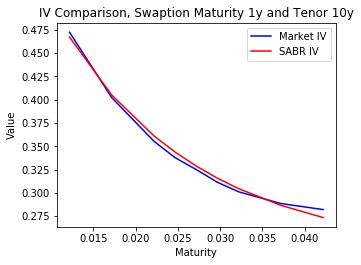

In [22]:
# Les données pour les swaptions de maturité 1 an et de ténor 10 ans sont contenu dans la ligne 18
Data_row = SwaptionsIV.iloc[18]  
alpha,rho,v = Calibrated_params_data[['alpha','rho','v']].iloc[18]
f = Data_row['Forward']
Strike = np.array([f -0.0001*150, f - 0.0001*100, f - 0.0001*50, f-0.0001*25, f, f+0.0001*25, f + 0.0001*50, f+0.0001*100, f+0.0001*150])

List_SABR_IV = np.array([SABRImpliedVol(f,K,alpha,rho,v) for K in Strike])
List_Mkt_IV = np.array([Data_row['Strike_Spread_equal_minus_150'], Data_row['Strike_Spread_equal_minus_100'], Data_row['Strike_Spread_equal_minus_50'], Data_row['Strike_Spread_equal_minus_25'], Data_row['Strike_Spread_equal_0'], Data_row['Strike_Spread_equal_25'],Data_row['Strike_Spread_equal_50'],Data_row['Strike_Spread_equal_100'],Data_row['Strike_Spread_equal_150']])

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(Strike,List_Mkt_IV, color = 'b', label = 'Market IV')
plt.plot(Strike,List_SABR_IV, color = 'r', label = 'SABR IV')
plt.xlabel('Maturity')
plt.ylabel('Value')
leg = ax.legend()
plt.title('IV Comparison, Swaption Maturity 1y and Tenor 10y')

Ainsi , la calibration semble correcte bien qu'il est possible de mieux faire, notamment avec la fonction minimize de scipy.optimize, qui est un outil puissant d'optimisation. Cela peut être dû au fait de la restriction de l'espace de définition de $\rho$ à des valeurs négatives par exemple. Dans tous les cas, il a été décidé de garder ces résultats de la calibration.

A partir de ces paramètres calibrés, il est possible de valoriser des produits dérivés exotiques à partir du modèle SABR.

## Pricing d'instruments exotiques

### Pricing d'une option barrière

Une option barrière est une option délivrant un payoff uniquement si le prix du sous-jacent ait franchi ou non une barrière. Plus particulièrement, dans le cas d'une option Up and Out, le payoff devient nul lorsque le sous-jacent franchit une certaine barrière entre le début et la maturité de l'option.

Plus précisément, dans le cadre de ce projet, il est question de considérer un caplet de type Up and Out At the Money, c'est à dire un caplet de Strike ATM, c'est à dire qu'il est égal au prix actuel du sous-jacent qui est le taux linéaire pour des prêts de durée $\delta$, et de Barrière égal à ATM + B, avec B strictement positif. Cette barrière provoque ainsi la désactivation du caplet lorsque le taux linéaire forward de maturité $T$ la franchit à tout moment de la vie du caplet.

Ainsi, le Strike $K$ de l'option est donné par $K = f$, $f$ étant le taux forward initial à l'instant $0$ égal aussi à $L(0,T,T+\delta)$, et le payoff du caplet Up and Out est donné par :

$$
\Pi_{Caplet}(T,\delta,f) = \delta(L(T, T+\delta) - f)_{+}\mathbb{1}_{sup_{s \in [0,T]} L(s,T, T+\delta) < f+B}
$$

Notons que lorsque la quantité $B$ de la barrière tend vers $+ \infty$, alors le payoff dudit caplet barrière tend vers celui d'un caplet européen classique, impliquant donc le même phénomène pour son prix à chaque instant $t$. Au contraire, si $B$ tend vers $- \infty$, alors le prix du caplet Up and Out à chaque instant tend vers zéro, étant donné qu'il est quasiment impossible d'avoir des taux divergeant négativement.

En l'absence d'opportunité d'arbitrage, si l'on pose $\mathbb{Q}$ la probabilité risque neutre et $r_t$ le taux sans risque, le théorème fondamental de la valorisation des actifs permet d'établir que le prix actuel d'un caplet est donné par :

$$
Caplet_{UO}(T,\delta,f) = \delta \mathbb{E}^{\mathbb{Q}}[e^{\int_0^{T+\delta} r_s ds}(L(T, T+\delta) - f)_{+}\mathbb{1}_{sup_{s \in [0,T]} L(s,T,T+\delta) < f+B}]
$$

De ce fait, en utilisant le même raisonnement que celui pour le pricing des caplets vanilles, le changement de numéraire selon la probabilité $T+\delta$ forward neutre permet d'obtenir le prix suivant :

$$
Caplet_{UO}(T,\delta,f) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L(T, T+\delta) - f)_{+}\mathbb{1}_{sup_{s \in [0,T]} L(s,T,T+\delta) < f+B}]
$$

#### Valorisation Monte Carlo sous le modèle SABR

L'équation différentielle stochastique du processus de taux forward EURIBOR $L_t = L(t,T,T+\delta)$ sous la probabilité $\mathbb{Q}^{T+\delta}$ est donné sous le modèle SABR par :

$$
\left\{
    \begin{array}{lll}
    dL_t =  \sigma_t L_t^{\beta} dW_t^1 \\
    d\sigma_t = v\sigma_t dW_t^2 \\
    \mathbb{E}^{\mathbb{Q}^{T+\delta}}[dW_t^1,dW_t^2] = d<W^1,W^2>_t =  \rho dt
    \end{array}
\right.
$$

Avec comme conditions initiale $L_0 = f$ et $\sigma_0 = \alpha$.

Il convient d'estimer le prix des caplets Up and Out par Monte Carlo. Pour cela, sachant que celui ci est caractérisé par l'ensemble de la trajectoire du taux forward $L_t$, étant donné la présence de la barrière désactivante, il convient de simuler non pas le processus à l'instant final $T$, mais l'ensemble de sa trajectoire entre l'instant $0$ et $T$. Pour cela, l'équation différentielle stochastique est discrétisé selon le Schéma d'Euler, en considérant une discrétisation du temps $(t_0 = 0,...,t_n = T)$ avec $t_i = \Delta i$ pour $i \in [|0,n|]$ et $\Delta = \frac{T}{n}$ le différentiel en pas de temps. 

Sous la probabilité $\mathbb{Q}^{T+\delta}$, les mouvements browniens $dW_t^1$ et $dW_t^2$ sont des variables gaussiennes de loi $\mathcal{N}(0,dt)$. 

Pour éviter toute négativité de la volatilité $\sigma_t$ et du taux forward $L_t$ et pour plus de stabilité dans les résultats, il conviendra de poser $x_t = ln(L_t/f)$ et $y_t = ln(\sigma_t)$. Le nouveau système d'équations différentielles stochastiques est donc donné selon le lemme d'Itô par :

$$
\left\{
    \begin{array}{lll}
    dx_t = - \frac{1}{2}e^{2 y_t + \beta x_t} dt + e^{y_t+ (\beta - 1)x_t} dW_t^1 \\
    dy_t = - v^2 dt + vdW_t^2  \\
    \mathbb{E}^{\mathbb{Q}^{T+\delta}}[dW_t^1,dW_t^2] = d<W^1,W^2>_t =  \rho dt
    \end{array}
\right.
$$

Avec comme condition initiale $x_0 = 0$ et $y_0 = ln(\alpha)$. En effet, la formule d'Itô permet d'établir que $dln(x_t) = \sigma_t L_t^{\beta - 1} dW_t^1 - \frac{1}{2} \sigma_t^2 L_t^{\beta} dt$ d'où le résultat.

Ainsi, pour $i \in [|0,n|]$, cette discrétisation est donnée par

$$
\left\{
    \begin{array}{lll}
    x_{t_{i+1}} -x_{t_i}=  - \frac{1}{2}e^{2 y_{t_i} + \beta x_{t_i}} \Delta + e^{y_{t_i}+ (\beta - 1)x_{t_i}} \sqrt{\Delta}\epsilon_1 \\
    y_{t_{i+1}} - y_{t_i}  = - v^2 \Delta + v\sqrt{\Delta}\epsilon_2  \\
    \epsilon_2 = \rho \epsilon_1 + \sqrt{1 - \rho^2}\epsilon 
    \end{array}
\right.
$$

avec $\epsilon$ suivant une loi normale centrée réduite indépendante de $\epsilon_1$ et $\epsilon_2$, qui suivent aussi la même loi. Il convient d'appliquer par la suite la transformation $L_T = fe^{x_T}$ pour retrouver le taux forward.

Sachant que le prix actuel d'un caplet Up and Out est donné par :

$$
Caplet_{UO}(T,\delta,f) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L(T, T+\delta) - f)_{+}\mathbb{1}_{sup_{s \in [0,T]} L(s,T,T+\delta) < f+B}]
$$

Alors en se rappelant que $L(T,T+\delta) = L_T$ qui est défini précédemment :

$$
Caplet_{UO}(T,\delta,f) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L_T - f)_{+}\mathbb{1}_{sup_{s \in [0,T]} L_s < f+B}]
$$

pour $M$ suffisamment grand pour s'assurer de la convergence de l'estimateur grâce à la Loi Forte des Grands Nombres, son estimateur Monte Carlo est donné par :

$$
\hat{Caplet_{UO}}(T,\delta,f) =  B(0,T+\delta)*\frac{1}{M}\sum_{j=1}^M[(L_T^j- f)_{+}\mathbb{1}_{max_{i \in [|0,n|]} L^j_{t_i} < f+B}]
$$

Pour résumer, la simulation Monte Carlo du prix actuel des caplets barrières Up and Out se fait comme suit :

L'opération ci dessous est répétée $M$ fois :
- On simule $n$ variables gaussiennes centrées réduites $\epsilon$ puis $\epsilon_1$ pour $j \in [|1,n|]$
- On calcule $\epsilon_2$ à partir de $\epsilon$ et $\epsilon_1$
- On pose $x_0 = 0$ et $y_0 = ln(\alpha)$ et on applique le schéma d'Euler sur l'équation différentielle stochastique pour $i \in [|0,n|]$ selon le système :

$$
\left\{
    \begin{array}{lll}
    x_{t_{i+1}} -x_{t_i}=  - e^{2 y_{t_i} + \beta x_{t_i}} \Delta + e^{y_{t_i}+ (\beta - 1)x_{t_i}} \sqrt{\Delta}\epsilon_1 \\
    y_{t_{i+1}} - y_{t_i}  = - v^2 \Delta + v\sqrt{\Delta}\epsilon_2 \\
    \epsilon_2 = \rho \epsilon_1 + \sqrt{1 - \rho^2}\epsilon 
    \end{array}
\right.
$$

Et à partir de la réalisation de ces $M$ Schéma d'Euler, on calcule $\hat{Caplet_{UO}}(T,\delta,K)$ selon la formule précédente, en prenant soin préalablement d'effectuer la transformation $L_T = fe^{x_T}$.

En posant la fonction $g$ qui est croissante en fonction du processus $L^j_T$ et définie telle que :

$$
g(L^j_T) = (L_T^j- f)_{+}\mathbb{1}_{max_{i \in [|0,n|]} L^j_{t_i} < f+B}
$$

Sa variance est donnée par :

$$
\sigma^2_{Caplet} = \frac{1}{M-1}\sum_{j=1}^M (g(L^j_T) - \hat{Caplet_{UO}}(T,\delta,f))^2
$$

Ce qui permet d'en établir un intervalle de confiance à 95% :

$$
IC_{95} = [Caplet_{UO}(T,\delta,f) - \frac{\sigma_{Caplet}}{\sqrt{M}}, Caplet_{UO}(T,\delta,f) + \frac{\sigma_{Caplet}}{\sqrt{M}}]
$$.

##### Méthode des variables antithétiques

Un des inconvénients majeurs de l'estimation traditionnelle de Monte Carlo telle qu'elle est définie ci dessus est la possibilité d'obtenir une variance trop élevée. Plus particulièrement, lorsque l'on simule une multitude de trajectoires de mouvements browniens standards, il est possible de constater qu'à l'instant final $T$, la variance de l'ensemble des variables $W^j_t$ est trop élevée, ce qui pose problème pour la stabilité des estimateurs.

C'est pourquoi des méthodes de réduction de variances sont utilisés pour effectuer les simulations de Monte Carlo. L'une des plus connues est la méthode des variables antithétiques, qui sera ici appliquée. Le raisonnement est expliqué comme suit :

Il convient dans un premier temps de remarquer la symétrie en loi des mouvements browniens standards, qui en est une propriété primordiale. En effet, les processus $(W_t)$ et $(-W_t)$ sont de même loi $\mathcal{N}(0,t)$. Par ailleurs, leur corrélation est négative ce qui a un effet négatif sur la variance de l'estimateur de Monte Carlo. 

En effet, si l'on souhaite estimer $I = \mathbb{E}[g(W_T)]$, $g$ étant une fonction mesurable du mouvement brownien en $T$, il est possible dans un premier temps de remarquer que $I = \frac{1}{2}(\mathbb{E}[g(W_T)] + \mathbb{E}[g(-W_T)])$. De ce fait, un estimateur par la méthode des variables antithétiques est donné par :

$$
\tilde{I} = \frac{1}{M}\sum_{j=1}^M \frac{g(W^j_T) + g(-W^j_T)}{2}
$$

La variance d'un tel estimateur fait intervenir la covariance du mouvement brownien et son opposé. La négativité de cette dernière permet ainsi une variance plus faible de $\tilde{I}$ que celle de l'estimateur traditionnelle de Monte Carlo.

Appliqué dans le cas présent, la méthode des variables antithétiques peut être détaillée comme suit :

L'opération ci dessous est répétée $M$ fois :

- On simule $n$ variables gaussiennes centrées réduites $\epsilon$ puis $\epsilon_1$ pour $j \in [|1,n|]$
- On calcule $\epsilon_2$ à partir de $\epsilon$ et $\epsilon_1$
- On pose $x_0 = 0$ et $y_0 = ln(\alpha)$ et on applique le schéma d'Euler sur l'équation différentielle stochastique pour $i \in [|0,n|]$ selon le système :

$$
\left\{
    \begin{array}{lll}
    x_{t_{i+1}} -x_{t_i}=  - \frac{1}{2} e^{2 y_{t_i} + \beta x_{t_i}} \Delta + e^{y_{t_i}+ (\beta - 1)x_{t_i}} \sqrt{\Delta}\epsilon_1 \\
    y_{t_{i+1}} - y_{t_i} = - v^2 \Delta - v\sqrt{\Delta}\epsilon_2 \\
    \epsilon_2 = \rho \epsilon_1 + \sqrt{1 - \rho^2}\epsilon 
    \end{array}
\right.
$$

- On considère l'opposé de l'ensemble des réalisation des variables aléatoires $\epsilon$, $\epsilon_1$, $\epsilon_2$
- Le schéma d'Euler est ensuite réappliqué pour obtenir les variables antithétiques selon le système en posant toujours $x^{anti}_0 = 0$ et $y^{anti}_0 = ln(\alpha)$ :

$$
\left\{
    \begin{array}{lll}
    x^{anti}_{t_{i+1}} -x^{anti}_{t_i}=  - \frac{1}{2} e^{2 y^{anti}_{t_i} + \beta x^{anti}_{t_i}} \Delta - e^{y^{anti}_{t_i}+ (\beta - 1)x^{anti}_{t_i}} \sqrt{\Delta}\epsilon_1 \\
    y^{anti}_{t_{i+1}} - y^{anti}_{t_i}  = - v^2 \Delta + v\sqrt{\Delta}\epsilon_2 \\
    \epsilon_2 = \rho \epsilon_1 + \sqrt{1 - \rho^2}\epsilon 
    \end{array}
\right.
$$

- On applique les transformations $L_T = fe^{x_T}$ et $L_T^{anti} = fe^{x_T^{anti}}$

Et à partir de la réalisation de ces $M$ Schéma d'Euler, l'estimateur par variables antithétiques du prix actuel d'un Caplet Up and Out est donnée par :

$$
\tilde{Caplet_{UO}}(T,\delta,K) =  B(0,T+\delta)*\frac{1}{M}\sum_{j=1}^M \frac{g(L^j_T) + g(L^j_T)}{2}
$$

avec :

$$
g(L^j_T) = (L_T^j- f)_{+}\mathbb{1}_{max_{i \in [|0,n|]} L^j_{t_i} < f+B}
$$

Cet estimateur converge vers le prix réel des caplets grâce à la loi des grands nombres, mais possède une variance réduite par rapport à l'estimateur traditionnel de Monte Carlo.

In [26]:
# n : nombre de simulations nécessaire pour construire une trajectoire de 0 à T pour S et sigma
# M : nombre de trajectoires à simuler pour calculer le prix du Call
# f est le taux forward initial
# B est la barrière

beta = 0.5

def fast_MC_SABR_UOCall(T,delta, f, B, alpha, rho, v, n, M):
    # On défini le zéro coupon en fonction de T, delta, et des données à disposition
    B0 = ZCAndForwardRates[round(ZCAndForwardRates['T'],2) == round(T+delta,2)]['ZCBond'].iloc[0]
    
    # On discrétise l'espace de temps
    Delta_t = T/n
    
    # On initialise la somme Monte Carlo
    G = 0
    
    # On initialise les trajectoires des variables F et sigma
    Traj_x = np.zeros((M,n+1))
    Traj_x[:,0] = np.array([0 for i in range(M)])
    
    Traj_y = np.zeros((M,n+1))
    Traj_y[:,0] = np.array([math.log(alpha) for i in range(M)])
    
    # On initialise les trajectoires de leur variables antithétiques
    Traj_x_Anti = np.zeros((M,n+1))
    Traj_x_Anti[:,0] = np.array([0 for i in range(M)])
    
    Traj_y_Anti = np.zeros((M,n+1))
    Traj_y_Anti[:,0] = np.array([math.log(alpha) for i in range(M)])
    
    # On simule M fois n les trois variables centrées réduites
    epsilon = np.random.normal(size = (M, n))
    epsilon1 = np.random.normal(size = (M, n))
    
    epsilon2 = rho*epsilon1 + np.sqrt(1-rho**2)*epsilon
    
    for i in range(n):
        
        # Application du Schéma d'Euler
        Traj_y[:, i+1] = Traj_y[:, i] + v*np.sqrt(Delta_t)*epsilon2[:, i]  - (v**2)*Delta_t      
        Traj_x[:, i+1] = Traj_x[:, i] - 0.5*np.exp(2*Traj_y[:, i] + beta*Traj_x[:,i])*Delta_t + np.exp(Traj_y[:, i] + (beta-1)*Traj_x[:,i])*np.sqrt(Delta_t)*epsilon1[:, i]
        
        # Application du schéma d'Euler pour les variables antithétiques
        Traj_y_Anti[:, i+1] = Traj_y_Anti[:, i] - v*np.sqrt(Delta_t)*epsilon2[:, i]  - (v**2)*Delta_t          
        Traj_x_Anti[:, i+1] = Traj_x_Anti[:, i] - 0.5*np.exp(2*Traj_y[:, i] + beta*Traj_x_Anti[:,i])*Delta_t - np.exp(Traj_y[:, i] + (beta-1)*Traj_x_Anti[:,i])*np.sqrt(Delta_t)*epsilon1[:, i]
        
        if (np.isnan(Traj_x[:, i+1]).any()):          
            #Dans certain cas l'exponentiel conduit à des erreurs numériques, on retire les nan et inf
            Traj_x[:, i+1] = np.nan_to_num(Traj_x[:,i+1])
            

        if (np.isnan(Traj_x_Anti[:, i+1]).any()):          
            #Dans certain cas l'exponentiel conduit à des erreurs numériques, on retire les nan et inf
            Traj_x_Anti[:, i+1] = np.nan_to_num(Traj_x_Anti[:,i+1])

    for j in range(M):
        
        # Application de la barrière désactivante : si le maximum de la trajectoire de ln(L_t) dépasse ln(f+B) , 
        # la valeur L_T à l'instant final T sera égal à f de sorte à annuler le payoff final.
        if max(Traj_x[j,:]) >= math.log(f+B) :
            L_T = f
        
        # De même pour la variable antithétique
        if max(Traj_x_Anti[j,:]) >= math.log(f+B) :
            L_T_Anti = f
            
    # On prend la dernière valeur de chaque trajectoire de L_t et sa version antithétique
    L_T = f*np.exp(Traj_x[:,-1])
    L_T_Anti = f*np.exp(Traj_x_Anti[:,-1])
    
    # On somme G avec la nouvelle valeur simulée
    G = (np.maximum(L_T-f, 0).sum() + np.maximum(L_T_Anti-f, 0).sum())/2
   
    # On applique la formule de pricing
    UO_Call_Price = (B0*G)/M
    
    # Return
    return UO_Call_Price

#### Cas particulier du pricing d'un Caplet sous le modèle SABR

Avant de valoriser un caplet barrière, il convient de faire de même sur un caplet vanille sur EURIBOR At the money, disons de maturité 1, de ténor 0.5 donc 6 Mois, et ceci sous le modèle SABR.

Rappelons que la valorisation sous modèle SABR d'un caplet vanille consiste à calculer la volatilité implicite SABR avec les paramètres calibrés et d'inférer celle ci dans le modèle de Black classique. Cependant, n'ayant pas de données calibrés à notre disposition pour les maturité de 1 an, il a été convenu de choisir les paramètres arbitrairement et de manière cohérente. Ainsi, dans ce cas précis :

In [27]:
alpha = 0.0542
beta = 0.5
rho = -0.356
v = 0.37

T=1
delta = 0.5
K = L0
sigma_SABR = SABRImpliedVol(L0,K,alpha,rho,v)

CapletSABR1 = BlackCaplet(T,delta,sigma_SABR,B0, L0, K)
print("Le prix SABR d'un Caplet EURIBOR 6 mois ATM et de Maturité 1 an avec une volatilité Black de 0.30 est égal %f" % (CapletSABR1))

Le prix SABR d'un Caplet EURIBOR 6 mois ATM et de Maturité 1 an avec une volatilité Black de 0.30 est égal 0.000427


#### Application du modèle SABR pour une option barrière

C'est ainsi que qu'un Caplet Barrière Up and Out, avec les même caractéristiques à l'exception d'une barrière désactivante $B = +\infty $ qui sera ajoutée. En théorie, son prix sera donc la même que celle d'un caplet vanille. Il s'agit ici de vérifier la bonne convergence de la méthode de valorisation vers la valeur voulue. De ce fait, la valorisation est la suivante sous le modèle SABR avec les mêmes paramètres :

In [42]:
B = math.inf
f = L0
UOCapletSABR = fast_MC_SABR_UOCall(T,delta, f, B, alpha, rho, v, 1000, 1000)
print("Le prix SABR d'un Caplet Barrière EURIBOR 6 mois ATM et de Maturité 1 an est égal %f" % (UOCapletSABR))

Le prix SABR d'un Caplet Barrière EURIBOR 6 mois ATM et de Maturité 1 an est égal 0.000076


Malheureusement, la valorisation Monte Carlo pour le Caplet Barrière avec $B = + \infty$ ne donne pas la même valeur que celui d'un Caplet Vanille, alors que théoriquement, leur valeur doit être égale. Ainsi, il convient de revoir la formule. Par manque de temps, cela ne fut possible, mais les travaux seront poursuivis afin de résoudre ce problème.

l'objectif final aurait été de valoriser le Caplet Barrière At the money pour plusieurs valeurs de la barrière $B$ et ainsi analyser son comportement, notamment si celui ci converge vers le prix d'un Caplet Vanille lorsque $B = +\infty$ et vers zéro lorsque $B = -\infty$.

# Annexes

## Modèle de Black

### Valorisation des Caplets

Il existe plusieurs produits dérivés de taux d'intérêts. L'un des plus connus est le caplet, un produit dérivé vanille pouvant être considéré comme une option d'achat (ou Call) dont le sous-jacent est un taux d'intérêt. Ainsi le détenteur d'un caplet peut se prémunir d'une hausse de taux d'intérêt et obtenir in fine un payoff à l'instant $T+\delta$ lorsque le taux variable $L(T,T+ \delta)$ qui prévaudra à cet instant $T$ pour des prêts de maturité $\delta$ excède le Strike $K$ fixé, en ayant le droit d'emprunter ou de prêter à ce taux fixe $K$ garanti, qui est souvent proche du taux forward (d'après Huyen Pham). Ainsi, le payoff d'un caplet est donné par :

$$
\Pi_{Caplet}(T,\delta,K) = \delta(L(T, T+\delta) - K)_{+}
$$

Et en l'absence d'opportunité d'arbitrage, si l'on pose $\mathbb{Q}$ la probabilité risque neutre et $r_t$ le taux sans risque, le théorème fondamental de la valorisation des actifs permet d'établir que le prix actuel d'un caplet est donné par :

$$
Caplet(T,\delta,K) = \delta \mathbb{E}^{\mathbb{Q}}[e^{\int_0^{T+\delta} r_s ds}(L(T, T+\delta) - K)_{+}]
$$

Si l'on pose $L_f(t,T,T+\delta)$ le taux forward à l'instant $t$ expirant à l'instant $T$ et de maturité $T+ \delta$, celui ci est tel que :

$$
L_f(t,T,T+\delta) = \frac{1}{\delta}(\frac{B(t,T)}{B(t,T+\delta)} -1)
$$

de sorte à pouvoir introduire la probabilité $T+\delta$ forward neutre, écrite $\mathbb{Q}^{T+\delta}$ équivalente à la probabilité risque neutre $\mathbb{Q}$, définie telle que :

$$
\frac{d\mathbb{Q}^{T+\delta}}{d\mathbb{Q}}= Z_t^{T+\delta} = \frac{e^{\int_t^{T+\delta} r_s ds}}{\mathbb{E}^{\mathbb{Q}}[e^{\int_t^{T+\delta} r_s ds}|\mathcal{F}_t]}
$$

En convenant de remarquer que : $\mathbb{E}^{\mathbb{Q}}[Z_t^{T+\delta}|\mathcal{F}_t] = 1$

Il convient de préciser par ailleurs que cette probabilité forward neutre est associée au numéraire $B(t,T+\delta)$, ce qui signifie qu'il est possible d'établir que pour un certain actif $X_t$, le processus $\frac{X_t}{B(t,T+\delta)}$ est une martingale sous cette probabilité :

$$
\frac{X_t}{B(t,T+\delta)} = \mathbb{E}^{\mathbb{Q}^{T+\delta}}[\frac{X_T}{B(T,T+\delta)}|\mathcal{F}_t]
$$


En particulier, il est possible de constater que l'expression du taux forward à l'instant $t$ est exprimé comme suit :

$$
L_f(t,T,T+\delta) = \frac{1}{\delta}(\frac{B(t,T)}{B(t,T+\delta)} -1) = \frac{1}{\delta}\frac{B(t,T)}{B(t,T+\delta)} -\frac{1}{\delta}
$$

Or, pour un contrat forward sur un zéro coupon de maturité $T$ pour un prêt de 1 euros d'une durée de $T+\delta$, il est possible de constater que l'inverse de son prix à l'instant $t$ est exprimé comme suit, grâce au changement de numéraire :

$$
\frac{1}{B_f(t,T,T+\delta)} = \frac{B(t,T)}{B(t,T+\delta)} = \mathbb{E}^{\mathbb{Q}^{T+\delta}}[\frac{B(T,T)}{B(T,T+\delta)}|\mathcal{F}_t] = \mathbb{E}^{\mathbb{Q}^{T+\delta}}[\frac{1}{B(T,T+\delta)}|\mathcal{F}_t]
$$

Ainsi, le taux forward à l'instant $t$ est égal à :

$$
L_f(t,T,T+\delta) = \frac{1}{\delta}\mathbb{E}^{\mathbb{Q}^{T+\delta}}[\frac{1}{B(T,T+\delta)}|\mathcal{F}_t] -\frac{1}{\delta} = \frac{1}{\delta}\mathbb{E}^{\mathbb{Q}^{T+\delta}}[\frac{1}{B(T,T+\delta)} - 1|\mathcal{F}_t] = \mathbb{E}^{\mathbb{Q}^{T+\delta}}[L(T,T+\delta)|\mathcal{F}_t]
$$

avec $L(T,T+\delta)$ le taux interbancaire prévalent à l'instant $T$ pour des prêts de durée $\delta$. Ainsi, la probabilité $T+\delta$ forward neutre est définie de sorte que le taux forward interbancaire $L_f(t,T,T+\delta)$ soit une martingale sous cette probabilité.

Il a été vu en début de partie que le prix actuel d'un caplet de strike $K$, de maturité $T$ et de ténor $\delta$ est donné par :

$$
Caplet(T,\delta,K) = \delta \mathbb{E}^{\mathbb{Q}}[e^{\int_0^{T+\delta} r_s ds}(L(T, T+\delta) - K)_{+}] = \delta B(0,T+\delta)\mathbb{E}^{\mathbb{Q}}[\frac{e^{\int_0^{T+\delta} r_s ds}}{B(0,T+\delta)}(L(T, T+\delta) - K)_{+}]
$$

Or il a été vu précédemment que la probabilité $T+\delta$ forward neutre était construite par rapport à la probabilité risque neutre de telle sorte que pour tout $t \in [0,T]$ :

$$
\frac{d\mathbb{Q}^{T+\delta}}{d\mathbb{Q}}= Z_t^{T+\delta} = \frac{e^{\int_t^{T+\delta} r_s ds}}{\mathbb{E}^{\mathbb{Q}}[e^{\int_t^{T+\delta} r_s ds}|\mathcal{F}_t]} =  \frac{e^{\int_t^{T+\delta} r_s ds}}{B(t,T+\delta)}
$$

Dans le cas où l'on souhaite valoriser selon l'instant 0, 

$$
\frac{d\mathbb{Q}^{T+\delta}}{d\mathbb{Q}}= Z_0^{T+\delta} = \frac{e^{\int_0^{T+\delta} r_s ds}}{\mathbb{E}^{\mathbb{Q}}[e^{\int_0^{T+\delta} r_s ds}|\mathcal{F}_t]} =  \frac{e^{\int_0^{T+\delta} r_s ds}}{B(0,T+\delta)}
$$


De ce fait, par un changement de numéraire selon la probabilité $T+\delta$ forward neutre, ce prix devient :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L(T, T+\delta) - K)_{+}]
$$

Sachant que le taux forward interbancaire $L(t,T, T+\delta)$, que l'on nommera simplement $L_t$, est une martingale sous la probabilité $T+\delta$ forward neutre, alors en posant le $\mathbb{Q}^{T+\delta}$ mouvement brownien $W^{\mathbb{Q}^{T+\delta}}_t$ et en admettant la volatilité du taux forward constante par rapport au temps comme c'est le cas dans l'univers de Black, sa dynamique est donnée par :

$$
\frac{dL_t}{L_t} = \sigma(T,\delta,K)dW^{\mathbb{Q}^{T+\delta}}_t
$$

Ainsi, l'expression du taux forward $L_t$ est :

$$
L_t = L_0exp(\sigma(T,\delta,K)W^{\mathbb{Q}^{T+\delta}}_t - \frac{1}{2}\sigma^2(T,\delta,K)t)
$$

Sachant que $W^{\mathbb{Q}^{T+\delta}}_t$ suit une loi normale $\mathcal{N}(0,t)$ sous la probabilité $T+\delta$ forward neutre, alors en posant la variable $Z$ gaussienne centrée réduite :

$$
L_t = L_0exp(\sigma(T,\delta,K)\sqrt{t}Z - \frac{1}{2}\sigma^2(T,\delta,K)t)
$$

Et le prix actuel d'un caplet est donné sous la probabilité historique par:

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta) \mathbb{E}[(L_0e^{\sigma(T,\delta,K)\sqrt{T}Z - \frac{1}{2}\sigma^2(T,\delta,K)T} - K)_{+}]
$$

Le calcul analytique de cette espérance, fortement analogue au raisonnement effectué pour le modèle de Black Scholes, donne :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta)(P_1 - P_2)
$$

avec :

- $P_1 = \mathbb{E}[L_0e^{\sigma(T,\delta,K)\sqrt{T}Z - \frac{1}{2}\sigma^2(T,\delta,K)T} \mathbb{1}_{L_0e^{\sigma(T,\delta,K)\sqrt{T}Z - \frac{1}{2}\sigma^2(T,\delta,K)T} \geq K}]$
- $P_2 = K \mathbb{E}[\mathbb{1}_{L_0e^{\sigma(T,\delta,K)\sqrt{T}Z - \frac{1}{2}\sigma^2(T,\delta,K)T} \geq K}] = K \mathbb{P}[L_0e^{\sigma(T,\delta,K)\sqrt{T}Z - \frac{1}{2}\sigma^2(T,\delta,K)T} \geq K]$

Ainsi, si l'on pose : $d = \frac{1}{v}(ln(\frac{L_0}{K}) +\frac{v^2}{2})$ avec $v =\sigma(T,\delta,K)\sqrt{T}$, alors :

$$
P_2 = K\mathcal{N}(d-v)
$$

Concernant la quantité $P_1$, celle-ci se calcule de la manière suivante , et grâce à un changement de variable intermédiaire :

$$
P_1 = \frac{L_0}{2\pi}\int_{L_0e^{\sigma(T,\delta,K)\sqrt{T}z - \frac{1}{2}\sigma^2(T,\delta,K)T} \geq K} e^{\sigma(T,\delta,K)\sqrt{T}z - \frac{1}{2}\sigma^2(T,\delta,K)T} e^{-\frac{z^2}{2}} dz = \frac{L_0}{2\pi}\int_{L_0e^{\sigma(T,\delta,K)\sqrt{T}z + \frac{1}{2}\sigma^2(T,\delta,K)T} \geq K} e^{-\frac{z^2}{2}} dz = L_0\mathcal{N}(d)
$$

C'est ainsi que le prix actuel d'un caplet de maturité $T$, de ténor $\delta$ et de Strike $K$ est donnée par la formule de Black :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta)(L_0\mathcal{N}(d)- K\mathcal{N}(d-v))
$$

En se rappelant que $L_0 = L(0,T,T+\delta)$ est le taux actuel forward de maturité $T$ et de ténor $\delta$.

### Valorisation des Swaptions

Supposons une swaption payeuse débutant au temps $T$ et de maturité $T_n$ c'est à dire de ténor $T_n - T$. le coupon c est le taux fixe.

Premièrement, le prix d'un swap de taux Le swap payeuse de taux fixe, de nominal 1 et de strike $K$ sur la période d’investissement $(T_0,T_n)$ au temps t est, d'après le théorème fondamental de la valorisation des actifs et sachant les flux futurs du produit: 

$$
P_{Swap}(t,T_0,T_n,K) = \sum_{i=1}^{n}B(t,T_i)(T_i - T_{i-1})[L(t,T_{i-1}, T_i) - K]
$$

où $L(t,T_{i-1}, T_i)$ est le taux forward, c'est à dire taux établi au temps $t$ et qui est appliquable sur la période $[T_{i-1}, T_i]$. Il s'agit par ailleurs du taux permettant de valoriser un Forward Rate Agreement (FRA) au temps $t$ à sa Juste Valeur selon l'absence d'opportunité d'arbitrage (le prix doit être nul au temps $t$). L'expression de ce taux Forward est :

$$
L(t,T_{i-1}, T_i) = \frac{1}{T_{i}-T_{i-1}}(\frac{B(t, T_{i-1})}{B(t, T_i)} - 1)
$$

De ce fait, en réinjectant cette formule dans le prix du swap, il s'en suit que :

$$
P_{Swap}(t,T_0,T_n,K)  = B(t,T_0) - B(t,T_n) - \sum_{i=1}^{n} KB(t,T_i)(T_i - T_{i-1})
$$

cela permet ainsi de trouver le taux dit Swap Forward $\omega_t$ qui est la valeur de $K$ permettant au contrat swap d'être à son Juste Prix, c'est à dire nul au temps $t$. Son expression est donné par :

$$
\omega_t = \frac{B(t,T_0) - B(t,T_n)}{lvl(t,T_n)}
$$

Avec

$$
lvl(t,T_n) =\sum_{i=0}^{n}(T_i - T_{i-1})B(t,T_i)
$$

Cette nouvelle quantité permet ainsi d'obtenir l'expression nouvelle du swap :

$$
P_{Swap}(t,T_0,T_n,K)= \omega_tlvl(t,T_n) - K lvl(t,T_n) = (\omega_t - K)lvl(t, T_n)
$$

Le Swaption quant à elle, est une option de Swap. Elle donne donc le droit, et non l'obligation, au détenteur d'exercer son swap (receveur de taux fixe dans ce projet). Plus précisément, une swaption payeuse est une option permettant d’entrer dans un swap payeur applicable au temps $T_0$, et prenant fin au temps $T_n$ (et donc de ténor $T_n - T_0$, de nominal ici égal à 1 et de strike K. Ainsi, $T_0$ est la maturité de l'option.

Ainsi, son cash-flow à maturité est simplement le maximum entre le prix du swap receveur de taux fixe évalué au temps $T_0$ et la valeur nulle. 

De ce fait, son prix au temps $t$ est donnée par  l'espérance de son cash-flow futur actualisé par le taux sans risque $r_t$, et donc :

$$
Swopt^{PAY}(t,T_0,T_n,K)=\mathbb{E}^{\mathbb{Q}}[e^{-\int_t^{T_0} r_udu}(\omega_{T_0} - K)_{+}lvl(T_0, T_n)]
$$

Ainsi donc, à l'instant $0$ le prix devient :

$$
Swopt^{PAY}(0,T_0,T_n,K)=\mathbb{E}^{\mathbb{Q}}[e^{-\int_0^{T_0} r_udu}(\omega_{T_0} - K)_{+}lvl(T_0, T_n)]
$$

Il est possible d'effectuer un changement de numéraire selon la probabilité Duration $\mathbb{Q}^{lvl}$ et de constater que le processus $\omega_t$ est une martingale sous cette probabilité. Sachant que pour un processus $X_t$, la formule de pricing est la suivante :

$$
X_t = lvl(t, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[\frac{X_T}{lvl(T, T_n)}|F_t]
$$

Nous pouvons établir que le prix actuel du swaption est :

$$
Swopt^{PAY}(0,T_0,T_n,K)=lvl(0, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[\frac{P_{Swaption}(T_0,T_0,T_n,K)}{lvl(T_0, T_n)}|F_0]
$$

Et étant donné que son prix à sa maturité $T_0$ est égal à son cash flow (qui est déterministe) et donc égal à :

$$
Swopt^{PAY}(T_0,T_0,T_n,K) = (\omega_{T_0} - K)_{+}lvl(T_0, T_n)
$$

Alors le prix final du Swaption est égal à :

$$
Swopt^{PAY}(0,T_0,T_n,K)= lvl(0, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[(\omega_{T_0} - K)_{+}]
$$

Il est possible de calculer directement la quantité $\mathbb{E}^{\mathbb{Q}^{lvl}}[(\omega_{T_0} - K)_{+}]$ pour arriver au modèle de Black.

En effet, sachant que $\omega_t = \frac{B(t,T_0) - B(t,T_n)}{lvl(t,T_n)}$ est une martingale sous la probabilité Duration $\mathbb{Q}^{lvl}$, alors en supposant sa volatilité constante par rapport au temps $t$, mais exprimée en fonction du Strike $K$, de la maturité $T_0$ et du ténor $T_n - T_0$ (volatilité qui est aussi celle côtée sur le marché), sa dynamique sous cette probabilité est donnée par :

$$
\frac{d\omega_t}{\omega_t} = \sigma(T_0,T_n,K)dW^{\mathbb{Q}^{lvl}}_t
$$

d'où son expression à l'instant $T_0$:

$$
\omega_{T_0} = \omega_0exp(\sigma(T_0,T_n,K)dW^{\mathbb{Q}^{lvl}}_{T_0} - \frac{1}{2}\sigma^2(T_0,T_n,K) T_0)
$$

Et le prix d'une swaption payeuse devient :

$$
Swopt^{PAY}(0,T_0,T_n,K)= lvl(0, T_n)\mathbb{E}^{\mathbb{Q}^{lvl}}[(\omega_0e^{\sigma(T_0,T_n,K)dW^{\mathbb{Q}^{lvl}}_{T_0} - \frac{1}{2}\sigma^2(T_0,T_n,K) T_0} - K)_{+}]
$$

Et un calcul analogue d'espérance que celui effectué pour la valorisation d'un caplet permet ainsi d'établir la formule de Black dans le cas d'une swaption payeuse :

$$
Swopt^{PAY}(0,T_0,T_n,K) = lvl(0, T_n)(\omega_0\mathcal{N}(d)- K\mathcal{N}(d-v))
$$

Avec :$d = \frac{1}{v}(ln(\frac{\omega_0}{K}) +\frac{v^2}{2})$ avec $v =\sigma(T_0,T_n,K)\sqrt{T_0}$.

## Cadre de Heath-Jarrow-Morton (HJM) et Volatilité de Ho & Lee

### Cadre de Heath-Jarrow-Morton

#### Dynamique du taux forward, des zéro-coupons et hypothèse d'absence d'opportunité d'arbitrage

Le framework de Heath-Jarrow-Morton spécifie la dynamique des taux forward $f(t,T)$ via leur volatilité locale de la manière suivante, en posant $\alpha(t,T)$ et $\sigma(t,T)$ des processus $\mathcal{F}_t$ adaptés :

$$
\left\{
    \begin{array}{ll}
    df(t,T) = \alpha(t,T)dt + \sigma(t,T)dW_t \\
    f(0,T) = f^{m}(0,T)
    \end{array}
\right.
$$

où $f^{m}(0,T)$ est le taux forward observé sur le marché. 

Par ailleurs, le taux forward peut s'exprimer en fonction du prix d'une obligation zéro coupon comme suit :

$$
f(t,T) = -\frac{\partial ln B(t,T)}{\partial T}
$$

De ce fait, cela permet d'établir le prix d'une obligation zéro-coupon de la manière suivante :

$$
B(t,T) = exp(-\int_t^T f(t,u)du)
$$

Ainsi, sachant par ailleurs que le taux court est égal à : $r_t = f(t,t)$, d'après la règle de Leibniz appliquée à la fonction $F(t,T) = -\int_t^T f(t,u)du$ permet d'établir que :

$$
dF(t,T) = f(t,t)dt -\int_t^T df(t,u)du = r_tdt -\int_t^T \alpha(t,u)dudt - \int_t^T \sigma(t,u)dudW_t
$$

En posant :

- $A(t,T) = \int_t^T \alpha(t,u)dudt$
- $\Sigma(t,T) = \int_t^T \sigma(t,u)du$

la dynamique devient : $dF(t,T) = r_tdt - A(t,T)dt - \Sigma(t,T)dW_t$
Ainsi, étant donné que $B(t,T) = exp(F(t,T))$, alors la formule d'Itô appliquée à la fonction exponentielle donne la dynamique suivante du zéro-coupon :

$$
dB(t,T) = B(t,T)[dF(t,T) - \frac{1}{2} d<F(.,T)>_t]
$$

d'où :

$$
dB(t,T) = B(t,T)[(r_t -A(t,T) + \frac{1}{2} \Sigma(t,T)^2) dt - \Sigma(t,T)dW_t]
$$

En émettant l'hypothèse d'absence d'opportunité d'arbitrage, il existe une probabilité risque neutre équivalente à la probabilité historique auquelle les prix actualisés des actifs sont des martingales. 

Or, en considérant $r_t$ le taux sans risque, la dynamique du prix actualisé des obligations zéro coupons sont :

$$
d(e^{-\int_t^T r_udu} B(t,T)) = e^{-\int_t^T r_udu}B(t,T)[(- A(t,T) + \frac{1}{2} \Sigma(t,T)^2) dt - \Sigma(t,T)dW_t]
$$

Si l'on pose $\theta(t)$ de sorte que :

$$
-\Sigma(t,T) \theta(t) = - A(t,T) + \frac{1}{2} \Sigma(t,T)^2
$$ 

et que la variable $L_T = exp(\int_0^T \theta(s)dW_t = - \frac{1}{2}\int_0^T \theta^2(s) ds)$, d'espérance 1, puisse définir une nouvelle probabilité $\mathbb{Q}$ sous la condition de Novikov (qui est ici admise), alors d'après le théorème de Girsanov, le processus $W^{\mathbb{Q}}_t = W_t - \int_0^t \theta(s)ds$ est un mouvement brownien sous $\mathbb{Q}$.

De ce fait, sous cette nouvelle probabilité $\mathbb{Q}$, la dynamique du prix actualisé des obligations zéro coupons sous $\mathbb{Q}$ devient :

$$
d(e^{-\int_t^T r_udu} B(t,T)) = -\Sigma(t,T) e^{-\int_t^T r_udu}B(t,T)(dW_t - \theta(t)dt) = \Sigma(t,T) e^{-\int_t^T r_udu}B(t,T)dW^{\mathbb{Q}}_t
$$

Et le prix actualisé des obligations zéro coupons sont bien des martingales sous cette probabilité $\mathbb{Q}$. Ainsi, cette probabilité nouvellement construite via le processus $(\theta(t))_t$ est bien une probabilité risque neutre, montrant que s'il existe un processus $(\theta(t))_t$ tel que :

$$
-\Sigma(t,T) \theta(t) = - A(t,T) + \frac{1}{2} \Sigma(t,T)^2
$$

Alors le modèle de Heath-Jarrow-Morton vérifie bien la condition d'absence d'opportunité d'arbitrage. Et la dynamique d'une obligation zéro coupon sous la probabilité risque neutre est donnée par :

$$
dB(t,T) = B(t,T)(r_t dt - \Sigma(t,T) dW^{\mathbb{Q}}_t)
$$

Par ailleurs, il est possible de réécrire la dynamique des taux forward $f(t,T)$ sous la probabilité risque neutre. Par la formule d'Itô appliquée à $lnB(t,T)$, il est possible d'obtenir :

$$
dlnB(t,T) = \frac{1}{B(t,T)}dB(t,T) - \frac{1}{2B(t,T)^2} d<B(t,T)>
$$

d'où :

$$
dlnB(t,T) = \frac{1}{B(t,T)}dB(t,T) - \frac{1}{2B(t,T)^2} d<B(t,T)> = (r_t - \frac{1}{2}(\Sigma(t,T))^2)dt - \Sigma(t,T) dW^{\mathbb{Q}}_t
$$

en intégrant entre 0 et $t$ nous avons :

$$
lnB(t,T) = lnB(0,T)  + \int_0^t (r_s - \frac{1}{2}(\Sigma(s,T))^2)ds - \int_0^t \Sigma(s,T) dW^{\mathbb{Q}}_s
$$

Or : $f(t,T) = -\frac{\partial ln B(t,T)}{\partial T}$. Ainsi, admettant qu'il est possible d'inverser la dérivée par rapport à $T$ et l'intégrale grâce à un théorème d'Intégration, il vient que :

$$
f(t,T) = \int_0^t \Sigma(s,T) \frac{\partial \Sigma(s,T)}{\partial T} ds + \int_0^t \frac{\partial \Sigma(s,T)}{\partial T} dW^{\mathbb{Q}}_s
$$

De ce fait, la dynamique du taux forward $f(t,T)$ est égale à :

$$
df(t,T)  = \frac{\partial \Sigma(t,T)}{\partial T}\Sigma(t,T)dt + \frac{\partial \Sigma(t,T)}{\partial T} dW^{\mathbb{Q}}_t
$$

Sachant que : $\Sigma(t,T) = \int_t^T \sigma(t,u)du$, alors $\frac{\partial \Sigma(t,T)}{\partial T} = \sigma(t,T)$ et la dynamique devient :

$$
df(t,T) = \sigma(t,T)\Sigma(t,T)dt + \sigma(t,T) dW^{\mathbb{Q}}_t
$$

En conclusion, le drift du taux forward sous laquelle l'absence d'opportunité d'arbitrage est respectée dépend entièrement de la volatilité $\sigma(t,T)$ et est égale à :

$$
\alpha(t,T) = \sigma(t,T)\Sigma(t,T) = \sigma(t,T)\int_t^T \sigma(t,u)du
$$

#### Formule de Black sous le cadre de Heath-Jarrow-Morton

Il convient par la suite de calibrer les modèles issus du cadre de Heath-Jarrow-Morton via le prix actuel des caplets. D'après les calculs précédents, l'expression de ce dernier sous la probabilité $T+\delta$ forward neutre est donnée par :

$$
Caplet(T,\delta,K) = \delta B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(L(T, T+\delta) - K)_{+}]
$$

Or il convient de rappeler que le taux interbancaire $L(T,T+\delta)$ est exprimé en fonction du prix des obligations zéro coupons de la manière suivante :

$$
L(T,T+\delta) = \frac{1}{\delta}(\frac{B(T,T)}{B(T,T+\delta)} -1) = \frac{1}{\delta}(\frac{1}{B(T,T+\delta)} -1)
$$

Ainsi, il est possible de réexprimer le prix d'un Caplet de la manière suivante :

$$
Caplet(T,\delta,K) =  B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(\frac{B(T,T)}{B(T,T+\delta)} -1 - \delta K)_{+}] =  B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(\frac{B(T,T)}{B(T,T+\delta)} - (1 + \delta K))_{+}]
$$

De ce fait, en posant $\beta_{T,\delta}(t) = \frac{B(t,T)}{B(t,T+\delta)}$ l'inverse du prix à l'instant $t$ d'un contrat forward sur une obligation zéro coupon prévalent en $T$ et de ténor $\delta$, il est possible d'établir que :

$$
Caplet(T,\delta,K) =  B(0,T+\delta) \mathbb{E}^{\mathbb{Q}^{T+\delta}}[(\beta_{T,\delta}(T) - (1 + \delta K))_{+}]
$$

Il convient de rappeler que le numéraire associé à la probabilité $T+\delta$ forward neutre étant le prix du zéro coupon $B(0,T+\delta)$, le taux forward interbancaire $L_t$ ainsi que le processus $\beta_{T,\delta}(t)$ sont des martingales sous cette probabilité.

En particulier, il est connu que la dynamique selon le cadre de Heath Jarrow Morton d'une obligation zéro coupon sous la probabilité risque neutre est donnée par :

$$
dB(t,T) = B(t,T)(r_t dt - \Sigma(t,T) dW^{\mathbb{Q}}_t)
$$

Par ailleurs, sachant que $\beta_{T,\delta}(t) = \frac{B(t,T)}{B(t,T+\delta)}$, alors un simple calcul d'Itô sur la fonction $f(x,y) = \frac{x}{y}$ avec $x = B(t,T)$ et $y = B(t,T+\delta)$ donne :

$$
d\beta_{T,\delta}(t) = d(\frac{B(t,T)}{B(t,T+\delta)}) = \frac{B(t,T)}{B(t,T+\delta)}[\Sigma(t,T+\delta)(\Sigma(t,T+\delta) - \Sigma(t,T))dt + (\Sigma(t,T+\delta) - \Sigma(t,T))dW^{\mathbb{Q}}_t]
$$

Ainsi, sachant que sous la probabilité $T+\delta$ forward neutre, le mouvement brownien associé à cette probabilité a pour dynamique :

$$
dW^{\mathbb{Q}^{T+\delta}}_t = dW^{\mathbb{Q}}_t+ \Sigma(t,T+\delta)dt
$$ 

le changement de numéraire permet d'établir la dynamique du processus $\beta_{T,\delta}(t)$ sous le modèle HJM de la manière suivante, sous la probabilité $T+\delta$ forward neutre:

$$
d\beta_{T,\delta}(t) = \frac{B(t,T)}{B(t,T+\delta)}[\Sigma(t,T+\delta)(\Sigma(t,T+\delta) - \Sigma(t,T))dt + (\Sigma(t,T+\delta) - \Sigma(t,T))(dW^{\mathbb{Q}^{T+\delta}}_t - \Sigma(t,T+\delta)dt)]
$$

D'où :

$$
d\beta_{T,\delta}(t) = \beta_{T,\delta}(t)(\Sigma(t,T+\delta) - \Sigma(t,T))dW^{\mathbb{Q}^{T+\delta}}_t
$$

Ainsi, l'expression de $\beta_{T,\delta}(T)$ est donnée par :

$$
\beta_{T,\delta}(T)  = \beta_{T,\delta}(0) exp(\int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))dW^{\mathbb{Q}^{T+\delta}}_t - \frac{1}{2}\int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt) 
$$

Or, sachant que l'intégrale de Wiener $\int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))dW^{\mathbb{Q}^{T+\delta}}_t$ est une variable aléatoire gaussienne de variance $\frac{1}{2}\int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt$,

alors en posant :

- $V^2(T) = \int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt$
- $Z$ une variable aléatoire centrée réduite 

il est possible de réexprimer $\beta_{T,\delta}(T)$ comme suit, sous la probabilité historique :

$$
\beta_{T,\delta}(T) = \beta_{T,\delta}(0)e^{V(T) Z -\frac{1}{2} V^2(T)}
$$

Et le prix d'un Caplet selon le modèle de Ho & Lee sous cette même probabilité est donné par :

$$
Caplet(T,\delta,K) = B(0,T+\delta) \mathbb{E}[\beta_{T,\delta}(0)(e^{V(T) Z -\frac{1}{2} V^2(T)} - (1 + \delta K))_{+}] =  B(0,T+\delta) \mathbb{E}[\beta_{T,\delta}(0)(e^{V(T) Z -\frac{1}{2} V^2(T)} - (1 + \delta K))_{+}]
$$

Or il a été vu précédemment dans le cadre du pricing selon la formule de Black que pour une volatilité $\sigma(T,\delta,K)$ constante par rapport au temps $t$ mais dépendant de la maturité $T$, du ténor $\delta$ et du strike $K$,

$$
\mathbb{E}[(L_0e^{\sigma(T,\delta,K)\sqrt{T}Z - \frac{1}{2}\sigma^2(T,\delta,K)T} - K)_{+}] = L_0\mathcal{N}(d)- K\mathcal{N}(d-v)
$$

avec $d = \frac{1}{v}(ln(\frac{L_0}{K}) -\frac{v^2}{2})$ et $v =\sigma(T,\delta,K)\sqrt{T}$

Dans le cadre de Heath-Jarrow-Morton, la quantité $\sigma(T,\delta,K)$ est égale à $V(T)$ . Par ailleurs, en remplaçant dans l'expression ci dessus $K$ par $1+\delta K$ et $L_0$ par $\beta_{T,\delta}(0)$, alors il est possible d'obtenir le prix d'un caplet selon le modèle :

$$
Caplet(T,\delta,K) =   B(0,T+\delta) (\beta_{T,\delta}(0)\mathcal{N}(d)- (1+\delta K)\mathcal{N}(d-v))
$$

avec :

$$d = \frac{1}{V(T)}(ln(\frac{\beta_{T,\delta}(0)}{1+\delta K}) +\frac{V^2(T)}{2}) = \frac{1}{V(T)}(ln(\frac{B(0,T)}{B(0,T+\delta)(1+\delta K)})) +\frac{V^2(T)}{2})
$$ 

et 

$$ 
V(T) = \int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt
$$

Ainsi, le prix d'un caplet selon la formule de Black dans le cadre de Heath-Jarrow-Morton peut s'écrire comme le produit du prix actuel $B(0,T+\delta)$ d'un zéro coupon de maturité $T+\delta$ et du prix Black d'un Call avec les paramètres suivant :

- Forward : $\beta_{T,\delta}(0) = \frac{B(0,T)}{B(0,T+\delta)}$
- Strike : $1 +\delta K$
- Maturité : $T$
- volatilité de Black : $\sigma^B = V(T) = \int_0^T (\Sigma(t,T+\delta) - \Sigma(t,T))^2 dt$

### Volatilité de Ho & Lee

#### Dynamique des taux forward et prix des obligations zéro-coupons

Etant donné que le cadre de Heath-Jarrow-Morton est vaster et qu'il existe une multitude de modèle, il convient de spécifier précisément la forme de la volatilité $\sigma(t,T)$ du taux forward $f(t,T)$ à partir d'un certain modèle. De ce fait, l'un des modèles les plus connues est celle établie par Ho & Lee, qui suppose tout simplement que cette volatilité est constante :

$$
\sigma(t,T) = \sigma
$$

De ce fait, $\Sigma(t,T) = \sigma^2 (T-t)$ et la dynamique du taux forward est donnée par :

$$
df(t,T) = \sigma^2 (T-t) + \sigma dW^{\mathbb{Q}}_t
$$

d'où par intégration entre 0 et $t$ :

$$
f(t,T) = f(0,T) + \sigma^2 t(T - \frac{t}{2}) + \sigma W^{\mathbb{Q}}_t
$$

Sachant que le taux court s'écrit $r_t = f(t,t)$, alors son expression est donnée par :

$$
r_t = f(t,t) = f(0,t) + \sigma^2 \frac{t^2}{2} + \sigma W^{\mathbb{Q}}_t
$$

Ainsi, en posant $X_t = r_t - f(0,t) = - \sigma^2 \frac{t^2}{2} + \sigma W^{\mathbb{Q}}_t$, par une simple application de la formule d'Itô, la dynamique de ce processus est égale à :

$$
dX_t = \sigma^2 tdt + \sigma dW^{\mathbb{Q}}_t
$$

et en réinjectant $X_t$ dans l'expression du taux forward $f(t,T)$, il vient que :

$$
f(t,T) = f(0,T) + X_t + \sigma^2t(T-t)
$$

En intégrant par rapport à la deuxième variable entre $t$ et $T$, sachant que le processus $X_t$ ne dépend pas de cette variable $T$, il est possible de constater que :

$$
\int_t^T f(t,u)du = \int_t^T f(0,u)du + X_t (T-t) + {\sigma^2}{2}t(T-t)^2 = \int_0^T f(0,u) - \int_0^t f(0,u) + X_t (T-t) + {\sigma^2}{2}t(T-t)^2
$$

Ainsi, sachant que le prix d'une obligation zéro coupon s'exprime en fonction du taux forward de la manière suivante :

$$
B(t,T) = exp(-\int_t^T f(t,s)ds)
$$,

Alors sachant que $exp(\int_0^T f(0,s)ds - \int_0^t f(0,s)ds) = \frac{exp(\int_0^T f(0,s)ds)}{exp(\int_0^t f(0,s)ds)} = \frac{B(0,T)}{B(0,t)}$, l'expression du prix d'une obligation zéro coupon sous le modèle de Ho & Lee est égale à :

$$
B(t,T) =\frac{B(0,T)}{B(0,t)} exp(-{\sigma^2}{2}t(T-t)^2 -X_t (T-t))
$$